In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from timm import create_model
import matplotlib.pyplot as plt
from PIL import Image
import random
import pickle
import os
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts  
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset class (as you defined above)
class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform, tokenizer, max_length=50):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(np.array(patch)) for patch in patches[:34]]
            patch_tensors = [self.patch_transform(patch) for patch in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)
        else:
            combined_patches = torch.zeros(34 * 3, 112, 112)

        diagnosis = "<|startoftext|>" + entry.get('diagnosis', '').replace("_x000D_", " ") + "<|endoftext|>"
        tokenized = self.tokenizer(diagnosis, padding="max_length", truncation=True,
                                   max_length=self.max_length, return_tensors="pt")

        return image, combined_patches, tokenized["input_ids"].squeeze(0), tokenized["attention_mask"].squeeze(0)
    

# -------------------------------
# Splitting dataset and creating loaders
# -------------------------------
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load data from pkl
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

task_classes = ['ra', 'normal']
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())  
balanced_data = [random.sample(data_by_class[cls], min_class_count) for cls in task_classes]
balanced_data = sum(balanced_data, [])  # Flatten list
augmented_data = balanced_data * 2

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset instantiation
full_dataset = FootDataset(augmented_data, train_transform, patch_transform, tokenizer)

# Splitting
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size])

# Loaders definition
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



# Model definition (Corrected)
class TwoBranchGPT2Model(nn.Module):
    def __init__(self, pretrained=True, gpt2_model="gpt2"):
        super(TwoBranchGPT2Model, self).__init__()
        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch = models.resnet50(pretrained=pretrained)
        resnet_patch.conv1 = nn.Conv2d(102, 64, kernel_size=7, stride=2, padding=3, bias=False)
        resnet_global.fc = nn.Identity()
        resnet_patch.fc = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch = resnet_patch

        self.patch_resize = nn.Conv2d(102, 3, kernel_size=1)
        self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model)
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.feature_dim = 4110
        self.gpt2_proj = nn.Linear(self.feature_dim, self.gpt2.config.n_embd)


    def forward(self, image, patches, text_input_ids=None, attention_mask=None):
        batch_size = patches.shape[0]

        num_patches = patches.shape[1] // 3
        patches_resized = patches.view(batch_size, num_patches * 3, 112, 112)
        patches_resized = F.interpolate(patches_resized, size=(224, 224), mode='bilinear', align_corners=False)

        patches_resized_swin = self.patch_resize(patches_resized)

        swin_global_features = self.swin_global.forward_features(image).mean(dim=[2, 3])
        swin_patch_features = self.swin_patch.forward_features(patches_resized_swin).mean(dim=[2, 3])

        resnet_global_features = self.resnet_global(image)
        resnet_patch_features = self.resnet_patch(patches_resized)

        combined_features = torch.cat((
            swin_global_features, swin_patch_features,
            resnet_global_features, resnet_patch_features
        ), dim=1)

        encoder_embeds = self.gpt2_proj(combined_features).unsqueeze(1)
        prompt_len = 5  # Length of visual prompt
        prompt_embeds = encoder_embeds.repeat(1, prompt_len, 1)

        if text_input_ids is not None:
            text_embeds = self.gpt2.transformer.wte(text_input_ids)
            inputs_embeds = torch.cat([prompt_embeds, text_embeds], dim=1)

            prompt_attention = torch.ones(batch_size, prompt_len).to(image.device)
            attention_mask = torch.cat([prompt_attention, attention_mask], dim=1)

            # Pad labels to account for prompt embeddings explicitly
            pad_token_id = self.tokenizer.pad_token_id
            padding_labels = torch.full((batch_size, prompt_len), pad_token_id, device=image.device)
            labels = torch.cat([padding_labels, text_input_ids], dim=1)

            outputs = self.gpt2(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                labels=labels
            )
            return outputs.loss, outputs.logits
        else:
            generated = self.gpt2.generate(
                inputs_embeds=prompt_embeds,
                max_length=50,
                num_beams=5,
                pad_token_id=self.tokenizer.eos_token_id
            )
            return self.tokenizer.decode(generated[0], skip_special_tokens=True)



# Training Loop
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoBranchGPT2Model().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

for epoch in range(10):
    model.train()
    total_loss = 0
    for images, patches, input_ids, attn_mask in train_loader:
        images, patches, input_ids, attn_mask = images.to(device), patches.to(device), input_ids.to(device), attn_mask.to(device)
        optimizer.zero_grad()
        loss, _ = model(images, patches, input_ids, attn_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/10] Loss: {avg_loss:.4f}")

# Generation example
def generate(model, image, patches, device, tokenizer):
    model.eval()
    with torch.no_grad():
        report = model(image.unsqueeze(0).to(device), patches.unsqueeze(0).to(device))
    return report

image, patches, _, _ = test_dataset[1]
generated_report = generate(model, image, patches, device, tokenizer)
print("Generated Report:", generated_report)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from timm import create_model
import matplotlib.pyplot as plt
from PIL import Image
import random
import pickle
import os
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts  
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider
import random
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset class (as you defined above)
class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform, tokenizer, max_length=50):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(np.array(patch)) for patch in patches[:34]]
            patch_tensors = [self.patch_transform(patch) for patch in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)
        else:
            combined_patches = torch.zeros(34 * 3, 112, 112)

        diagnosis = "<|startoftext|>" + entry.get('diagnosis', '').replace("_x000D_", " ") + "<|endoftext|>"
        tokenized = self.tokenizer(diagnosis, padding="max_length", truncation=True,
                                   max_length=self.max_length, return_tensors="pt")

        return image, combined_patches, tokenized["input_ids"].squeeze(0), tokenized["attention_mask"].squeeze(0)
    

# -------------------------------
# Splitting dataset and creating loaders
# -------------------------------
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load data from pkl
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

task_classes = ['ra', 'normal']
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())  
balanced_data = [random.sample(data_by_class[cls], min_class_count) for cls in task_classes]
balanced_data = sum(balanced_data, [])  # Flatten list
augmented_data = balanced_data * 2

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset instantiation
full_dataset = FootDataset(augmented_data, train_transform, patch_transform, tokenizer)

# Splitting
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size])

# Loaders definition
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



# Model definition (Corrected)
class TwoBranchGPT2Model(nn.Module):
    def __init__(self, pretrained=True, gpt2_model="gpt2"):
        super(TwoBranchGPT2Model, self).__init__()
        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch = models.resnet50(pretrained=pretrained)
        resnet_patch.conv1 = nn.Conv2d(102, 64, kernel_size=7, stride=2, padding=3, bias=False)
        resnet_global.fc = nn.Identity()
        resnet_patch.fc = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch = resnet_patch

        self.patch_resize = nn.Conv2d(102, 3, kernel_size=1)
        self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model)
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.feature_dim = 4110
        self.gpt2_proj = nn.Linear(self.feature_dim, self.gpt2.config.n_embd)


    def forward(self, image, patches, text_input_ids=None, attention_mask=None):
        batch_size = patches.shape[0]

        num_patches = patches.shape[1] // 3
        patches_resized = patches.view(batch_size, num_patches * 3, 112, 112)
        patches_resized = F.interpolate(patches_resized, size=(224, 224), mode='bilinear', align_corners=False)

        patches_resized_swin = self.patch_resize(patches_resized)

        swin_global_features = self.swin_global.forward_features(image).mean(dim=[2, 3])
        swin_patch_features = self.swin_patch.forward_features(patches_resized_swin).mean(dim=[2, 3])

        resnet_global_features = self.resnet_global(image)
        resnet_patch_features = self.resnet_patch(patches_resized)

        combined_features = torch.cat((
            swin_global_features, swin_patch_features,
            resnet_global_features, resnet_patch_features
        ), dim=1)

        encoder_embeds = self.gpt2_proj(combined_features).unsqueeze(1)
        prompt_len = 5  # Length of visual prompt
        prompt_embeds = encoder_embeds.repeat(1, prompt_len, 1)

        if text_input_ids is not None:
            text_embeds = self.gpt2.transformer.wte(text_input_ids)
            inputs_embeds = torch.cat([prompt_embeds, text_embeds], dim=1)

            prompt_attention = torch.ones(batch_size, prompt_len).to(image.device)
            attention_mask = torch.cat([prompt_attention, attention_mask], dim=1)

            # Pad labels to account for prompt embeddings explicitly
            pad_token_id = self.tokenizer.pad_token_id
            padding_labels = torch.full((batch_size, prompt_len), pad_token_id, device=image.device)
            labels = torch.cat([padding_labels, text_input_ids], dim=1)

            outputs = self.gpt2(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                labels=labels
            )
            return outputs.loss, outputs.logits
        else:
            generated = self.gpt2.generate(
                inputs_embeds=prompt_embeds,
                max_length=50,
                num_beams=5,
                pad_token_id=self.tokenizer.eos_token_id
            )
            return self.tokenizer.decode(generated[0], skip_special_tokens=True)



# Training Loop
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoBranchGPT2Model().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    loop = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]', leave=True)
    for images, patches, input_ids, attn_mask in loop:
        images, patches = images.to(device), patches.to(device)
        input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)

        optimizer.zero_grad()
        loss, _ = model(images, patches, input_ids, attn_mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")


def generate(model, image, patches, device, tokenizer):
    model.eval()
    with torch.no_grad():
        report = model(image.unsqueeze(0).to(device), patches.unsqueeze(0).to(device))
    return report

# Randomly select 5 samples from test dataset
num_samples = 5
indices = random.sample(range(len(test_dataset)), num_samples)

bleu_scores, rouge_scores, meteor_scores = [], [], []

print("\n📌 **Generating Reports and Evaluation:**\n")
for i, idx in enumerate(indices, 1):
    image, patches, input_ids, _ = test_dataset[idx]

    # Generate report
    generated_report = generate(model, image, patches, device, tokenizer)

    # Decode ground truth
    ground_truth = tokenizer.decode(input_ids, skip_special_tokens=True)

    # Compute evaluation metrics
    bleu = sentence_bleu([ground_truth.split()], generated_report.split())
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_score = rouge.score(ground_truth, generated_report)['rougeL'].fmeasure
    try:
        meteor = meteor_score([ground_truth], generated_report)
    except:
        meteor = 0.0

    # Append scores
    bleu_scores.append(bleu)
    rouge_scores.append(rouge_score)
    meteor_scores.append(meteor)

    # Print results
    print(f"🔹 Sample {i}:")
    print(f"📍 Ground Truth: {ground_truth}")
    print(f"✅ Generated: {generated_report}")
    print(f"🔸 BLEU: {bleu:.4f} | ROUGE-L: {rouge_score:.4f} | METEOR: {meteor:.4f}")
    print("-" * 80)

# Print average evaluation scores
print("\n📊 **Average Evaluation Metrics Across 5 Samples:**")
print(f"🔹 Avg BLEU Score: {np.mean(bleu_scores):.4f}")
print(f"🔹 Avg ROUGE-L Score: {np.mean(rouge_scores):.4f}")
print(f"🔹 Avg METEOR Score: {np.mean(meteor_scores):.4f}")



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import pickle
import random
import numpy as np
import os
import pandas as pd
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt
from tqdm import tqdm 

# After your imports
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load dataset
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Specify classification task
task_classes = ['ra', 'normal']

# Balance dataset
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())
balanced_data = [random.sample(data_by_class[cls], min_class_count) for cls in task_classes]
balanced_data = sum(balanced_data, [])

# Data Augmentation
augmented_data = balanced_data * 2  

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(patch) for patch in patches[:34]]
            patch_tensors = [self.patch_transform(patch) for patch in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)
        else:
            combined_patches = torch.zeros(34 * 3, 112, 112)

        label = 1 if entry['class'].lower() == task_classes[0] else 0

        # Clean and tokenize report
        report_text = entry['diagnosis'].replace('_x000D_', ' ').strip()
        encoded_report = self.tokenizer(report_text, padding="max_length", max_length=128, truncation=True, return_tensors="pt")

        return image, combined_patches, label, encoded_report['input_ids'].squeeze(), encoded_report['attention_mask'].squeeze()

full_dataset = FootDataset(augmented_data, train_transform, patch_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ------------------------
# Model Definition
# ------------------------
class TwoBranchWithGPT2(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchWithGPT2, self).__init__()

        # Vision Transformer Encoder
        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        # ResNet Encoders
        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch = models.resnet50(pretrained=pretrained)
        feature_dim = resnet_global.fc.in_features  # 2048 for ResNet

        resnet_global.fc = nn.Identity()
        resnet_patch.fc = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch = resnet_patch

        # Channel Reduction for Patch Data
        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)

        # Feature Attention Module (Fixed Feature Size)
        self.feature_attention = nn.Sequential(
            nn.Linear(5632, 768),  # Fix: Ensure correct feature size for GPT-2
            nn.ReLU()
        )

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # GPT-2 Configuration with Cross-Attention
        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)

        # GPT-2 Decoder for Report Generation
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt2_config)

        # Initialize missing weights manually
        for name, param in self.gpt2.named_parameters():
            if 'crossattention' in name:
                param.data.normal_(mean=0.0, std=0.02)


    def forward(self, image, patches, input_ids=None, attention_mask=None):
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        patches_reduced = self.patch_channel_reduction(patches_resized)

        # Extract features
        swin_global_features = self.swin_global.forward_features(image).mean(dim=[1, 2])  # (batch, 768)
        swin_patch_features = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])  # (batch, 768)
        resnet_global_features = self.resnet_global(image)  # (batch, 2048)
        resnet_patch_features = self.resnet_patch(patches_reduced).reshape(patches.size(0), -1)  # (batch, 2048)

        # Merge features
        combined_features = torch.cat(
            [swin_global_features, swin_patch_features, resnet_global_features, resnet_patch_features], dim=1
        )  # (batch, 5632)

        # Reduce to GPT-2's expected input size
        projected_features = self.feature_attention(combined_features)  # (batch, 768)

        # Classification output
        classifier_output = self.classifier(projected_features)

        if input_ids is not None:
            # Expand along sequence length and ensure contiguous memory
            projected_features = projected_features.unsqueeze(1).expand(-1, input_ids.size(1), -1).contiguous()

            # Generate text using GPT‑2 with cross-attention
            gpt_output = self.gpt2(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                encoder_hidden_states=projected_features
            )
            return classifier_output, gpt_output.logits
        else:
            return classifier_output





# ------------------------
# Training & Evaluation
# ------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchWithGPT2(pretrained=True).to(device)

criterion_cls = nn.BCELoss()
criterion_txt = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


def evaluate(model, dataloader, criterion_cls, criterion_txt):
    model.eval()
    total_loss_cls = 0.0
    total_loss_txt = 0.0
    correct = 0
    total = 0
    rouge = Rouge()

    all_bleu_scores = []
    all_rouge_scores = []

    with torch.no_grad():
        for images, patches, labels, input_ids, attention_mask in dataloader:
            images, patches, labels, input_ids, attention_mask = (
                images.to(device), 
                patches.to(device), 
                labels.to(device).unsqueeze(1).float(),
                input_ids.to(device), 
                attention_mask.to(device)
            )

            outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
            loss_cls = criterion_cls(outputs, labels)
            loss_txt = criterion_txt(gpt_outputs.view(-1, gpt_outputs.size(-1)), input_ids.view(-1))
            
            total_loss_cls += loss_cls.item()
            total_loss_txt += loss_txt.item()

            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Generate Reports
            generated_ids = torch.argmax(gpt_outputs, dim=-1)
            generated_reports = [tokenizer.decode(gid, skip_special_tokens=True) for gid in generated_ids]
            ground_truth_reports = [tokenizer.decode(gid, skip_special_tokens=True) for gid in input_ids]

            # Evaluate Reports
            for gt, gen in zip(ground_truth_reports, generated_reports):
                # BLEU Score
                gt_tokens = gt.split()
                gen_tokens = gen.split()
                bleu_score = sentence_bleu([gt_tokens], gen_tokens)
                all_bleu_scores.append(bleu_score)

                # ROUGE Score
                rouge_scores = rouge.get_scores(gen, gt)
                all_rouge_scores.append(rouge_scores[0]["rouge-l"]["f"])

    avg_loss_cls = total_loss_cls / len(dataloader)
    avg_loss_txt = total_loss_txt / len(dataloader)
    accuracy = correct / total
    avg_bleu = sum(all_bleu_scores) / len(all_bleu_scores)
    avg_rouge = sum(all_rouge_scores) / len(all_rouge_scores)

    return avg_loss_cls, avg_loss_txt, accuracy, avg_bleu, avg_rouge


# Training Loop with Evaluation
train_losses_cls, val_losses_cls = [], []
train_losses_txt, val_losses_txt = [], []
train_accuracies, val_accuracies = [], []
train_bleu_scores, val_bleu_scores = [], []
train_rouge_scores, val_rouge_scores = [], []

for epoch in range(5):
    model.train()
    running_loss_cls = 0.0
    running_loss_txt = 0.0
    correct_train = 0
    total_train = 0

    print(f"\nEpoch {epoch+1} Training:")
    train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)

    for images, patches, labels, input_ids, attention_mask in train_loader_tqdm:
        images, patches, labels, input_ids, attention_mask = (
            images.to(device), patches.to(device), labels.to(device).unsqueeze(1).float(),
            input_ids.to(device), attention_mask.to(device)
        )

        optimizer.zero_grad()
        outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)

        loss_cls = criterion_cls(outputs, labels.float())

        # ✅ FIX: Use .reshape() instead of .view()
        loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

        loss = loss_cls + loss_txt

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss_cls += loss_cls.item()
        running_loss_txt += loss_txt.item()

        preds = (outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        # Update tqdm progress bar
        train_loader_tqdm.set_postfix({"Loss CLS": loss_cls.item(), "Loss TXT": loss_txt.item()})



    train_loss_cls = running_loss_cls / len(train_loader)
    train_loss_txt = running_loss_txt / len(train_loader)
    train_acc = correct_train / total_train

    # Validation with tqdm
    print(f"\nEpoch {epoch+1} Validation:")
    val_loader_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False)
    val_loss_cls, val_loss_txt, val_acc, val_bleu, val_rouge = evaluate(model, val_loader_tqdm, criterion_cls, criterion_txt)

    train_losses_cls.append(train_loss_cls)
    val_losses_cls.append(val_loss_cls)
    train_losses_txt.append(train_loss_txt)
    val_losses_txt.append(val_loss_txt)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_bleu_scores.append(val_bleu)
    train_rouge_scores.append(val_rouge)

    tqdm.write(f"Epoch {epoch+1}:")
    tqdm.write(f"Train Loss: [CLS: {train_loss_cls:.4f}, TXT: {train_loss_txt:.4f}], Accuracy: {train_acc:.4f}")
    tqdm.write(f"Val Loss:   [CLS: {val_loss_cls:.4f}, TXT: {val_loss_txt:.4f}], Accuracy: {val_acc:.4f}")
    tqdm.write(f"Val BLEU: {val_bleu:.4f}, Val ROUGE-L: {val_rouge:.4f}")
    tqdm.write("-" * 60)

print("Training Complete!")

# ------------------------
# Test Phase with Progress Bar
# ------------------------
print("\nTesting Model:")
test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False)
test_loss_cls, test_loss_txt, test_acc, test_bleu, test_rouge = evaluate(model, test_loader_tqdm, criterion_cls, criterion_txt)

tqdm.write(f"Test Loss: [CLS: {test_loss_cls:.4f}, TXT: {test_loss_txt:.4f}], Accuracy: {test_acc:.4f}")
tqdm.write(f"Test BLEU: {test_bleu:.4f}, Test ROUGE-L: {test_rouge:.4f}")


# ------------------------
# Plot Training Curves
# ------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_losses_cls, label='Train Loss (CLS)', marker='o')
plt.plot(val_losses_cls, label='Val Loss (CLS)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss Curve')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses_txt, label='Train Loss (TXT)', marker='o')
plt.plot(val_losses_txt, label='Val Loss (TXT)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Text Generation Loss Curve')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_bleu_scores, label='BLEU Score', marker='o')
plt.plot(train_rouge_scores, label='ROUGE-L Score', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Report Quality Evaluation')
plt.legend()
plt.grid()
plt.show()

# ------------------------
# Print Sample Reports
# ------------------------
print("\n=== Sample Ground Truth and Generated Reports ===\n")
model.eval()
with torch.no_grad():
    images, patches, labels, input_ids, attention_mask = next(iter(test_loader))
    images, patches, input_ids, attention_mask = (
        images.to(device), patches.to(device), input_ids.to(device), attention_mask.to(device)
    )
    
    outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
    generated_ids = torch.argmax(gpt_outputs, dim=-1)
    generated_reports = [tokenizer.decode(gid, skip_special_tokens=True) for gid in generated_ids]
    ground_truth_reports = [tokenizer.decode(gid, skip_special_tokens=True) for gid in input_ids]

    for i in range(5):  # Print 5 examples
        print(f"🔹 Ground Truth Report {i+1}:\n{ground_truth_reports[i]}")
        print(f"🔹 Generated Report {i+1}:\n{generated_reports[i]}")
        print("-" * 60)


In [ ]:
import torch
from tqdm import tqdm

# --- Inference on Test Dataset ---
model.eval()

all_preds = []
all_labels = []
all_generated_reports = []
all_ground_truth_reports = []

test_progress = tqdm(test_loader, desc="Running Inference on Test Set")

with torch.no_grad():
    for images, patches, labels, input_ids, attention_mask in test_progress:
        # Move everything to device
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).unsqueeze(1).float()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Forward pass
        cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
        
        # Classification predictions: threshold at 0.5
        preds = (cls_outputs >= 0.5).long().squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy().flatten())

        # Text generation
        generated_ids = torch.argmax(gpt_outputs, dim=-1)
        
        # Decode to text
        generated_reports = [tokenizer.decode(gid, skip_special_tokens=True) for gid in generated_ids]
        ground_truth_reports = [tokenizer.decode(gid, skip_special_tokens=True) for gid in input_ids]

        all_generated_reports.extend(generated_reports)
        all_ground_truth_reports.extend(ground_truth_reports)

# --- Compute Final Metrics ---
# Compute classification accuracy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean()

# If you want other classification metrics:
# from sklearn.metrics import classification_report, confusion_matrix
# print(classification_report(all_labels, all_preds, target_names=task_classes))
# print(confusion_matrix(all_labels, all_preds))

print(f"\nTest Classification Accuracy: {accuracy:.4f}")

# Evaluate Text Generation with BLEU and ROUGE
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

rouge = Rouge()
bleu_scores = []
rouge_l_f_scores = []

for ref_text, gen_text in zip(all_ground_truth_reports, all_generated_reports):
    ref_tokens = ref_text.split()
    gen_tokens = gen_text.split()
    bleu = sentence_bleu([ref_tokens], gen_tokens)
    bleu_scores.append(bleu)

    # ROUGE-L
    rouge_score = rouge.get_scores(gen_text, ref_text)
    rouge_l_f_scores.append(rouge_score[0]["rouge-l"]["f"])

avg_bleu = np.mean(bleu_scores)
avg_rouge_l = np.mean(rouge_l_f_scores)
print(f"Test BLEU: {avg_bleu:.4f}")
print(f"Test ROUGE-L: {avg_rouge_l:.4f}")

# --- Print Sample Results ---
print("\n=== Sample Predictions ===\n")
for i in range(3):  # show 3 samples
    print(f"True Label: {all_labels[i]} | Predicted Label: {all_preds[i]}")
    print(f"🔹 Ground Truth Report:\n{all_ground_truth_reports[i]}")
    print(f"🔹 Generated Report:\n{all_generated_reports[i]}")
    print("-" * 60)


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Epoch 1/1 ...


Epoch 1:
  Train Loss: CLS=0.6833, TXT=1.4346, Acc=0.5896
  Val   Loss: CLS=0.6747, TXT=0.0773, Acc=0.8333
Training Complete!


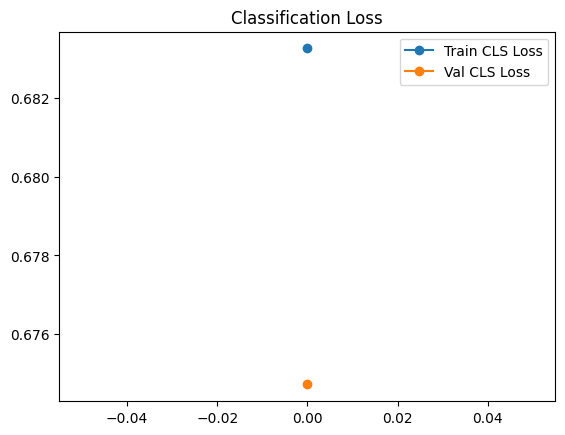

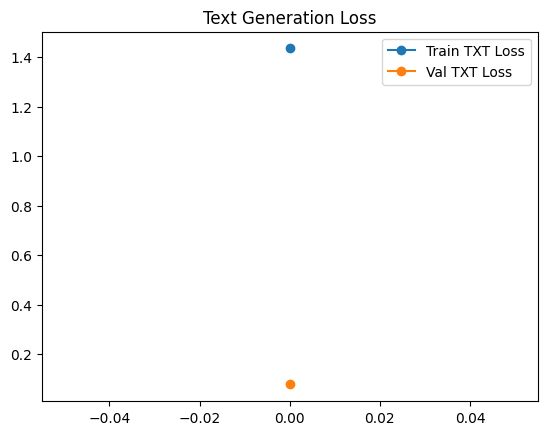


=== TEST PHASE ===


Testing:   0%|          | 0/4 [00:00<?, ?it/s]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.1264255940914154
Projected Features Std: 0.25670474767684937
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 1]), Max=50256, Min=50256
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 2]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 3]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 4]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 5]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 6]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 7]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 8]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 9]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 10]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 11]), Max=50256, Min=12
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 1

Testing:  25%|██▌       | 1/4 [00:12<00:37, 12.37s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.11917070299386978
Projected Features Std: 0.24497616291046143
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 1]), Max=50256, Min=50256
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 2]), Max=50256, Min=13
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 3]), Max=50256, Min=13
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 4]), Max=50256, Min=1
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 5]), Max=50256, Min=1
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 6]), Max=50256, Min=1
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 7]), Max=50256, Min=1
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 8]), Max=50256, Min=1
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 9]), Max=50256, Min=1
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 10]), Max=50256, Min=1
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 11]), Max=50256, Min=1
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 12]), Ma

Testing:  50%|█████     | 2/4 [00:24<00:24, 12.45s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.12114635109901428
Projected Features Std: 0.24785596132278442
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 1]), Max=50256, Min=50256
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 2]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 3]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 4]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 5]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 6]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 7]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 8]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 9]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 10]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 11]), Max=50256, Min=11
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 

Testing:  75%|███████▌  | 3/4 [00:37<00:12, 12.56s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.1373710036277771
Projected Features Std: 0.2948448956012726
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 1]), Max=50256, Min=50256
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 2]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 3]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 4]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 5]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 6]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 7]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 8]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 9]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 10]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 11]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 12]), Max=5025

🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 60]), Max=50256, Min=58
Test Classification Accuracy: 0.7818
Test BLEU:     0.0000
Test ROUGE-L:  0.0201

=== Sample Reports ===

[Ground Truth]:
[ Finding ] 
no significant bony lesion on radiographs. 
 
[ Conclusion ] 
no significant bony lesion on radiographs. 
 
[ Recommend ]
[Generated]   :
.".......................................... by by by by by by by by by by by by by by by by by
--------------------------------------------------
[Ground Truth]:
[FINDING       ] both 5th MTP joint, RA, suggested.  [CONCLUSION    ] both 5th MTP joint, RA, suggested.  [RECOMMENDATION] -
[Generated]   :


..........................................................
--------------------------------------------------
[Ground Truth]:
[ Finding ] 
no bony lesion. 
[ Diagnosis ] 
no bony lesion. 
[ Recommend ]
[Generated]   :
 " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " "
-------

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import pickle
import random
import numpy as np
import os
import pandas as pd
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Metrics / Utilities
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------- STEP 1: PREPARE DATA -------------
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# GPT2 doesn't have an official pad token, so we alias the EOS token as pad
tokenizer.pad_token = tokenizer.eos_token

# Load dataset (replace with your actual pkl path)
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Classification classes
task_classes = ['ra', 'normal']

# Balance dataset
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())
balanced_data = []
for cls in task_classes:
    balanced_data.extend(random.sample(data_by_class[cls], min_class_count))

# Optionally, repeat for "data augmentation" if you wish
augmented_data = balanced_data * 2

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        # Patch images
        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(patch) for patch in patches[:34]]  # up to 34 patches
            patch_tensors = [self.patch_transform(p) for p in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)  # shape (34*3, 112, 112)
        else:
            combined_patches = torch.zeros(34*3, 112, 112)  # placeholder if no patches

        # Label
        label = 1 if entry['class'].lower() == task_classes[0] else 0

        # Report text
        report_text = entry['diagnosis'].replace('_x000D_', ' ').strip()
        encoded_report = self.tokenizer(
            report_text,
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        return (
            image,
            combined_patches,
            label,
            encoded_report['input_ids'].squeeze(),
            encoded_report['attention_mask'].squeeze()
        )

# Split train/val/test
full_dataset = FootDataset(augmented_data, train_transform, patch_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

# ------------- STEP 2: MODEL DEFINITION -------------
class TwoBranchWithGPT2(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchWithGPT2, self).__init__()

        # -- SWIN --
        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()

        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        # -- ResNet --
        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch  = models.resnet50(pretrained=pretrained)
        resnet_global.fc = nn.Identity()
        resnet_patch.fc  = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch  = resnet_patch

        # -- For converting channel dimension from 102->3 for patches
        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)

        # -- Merge + project to GPT2 hidden size (768) --
        self.feature_attention = nn.Sequential(
            nn.Linear(5632, 768),  # 768 for GPT2
            nn.ReLU()
        )

        # -- Classification head --
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # -- GPT-2 with cross-attention --
        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt2_config)
        self.gpt2.resize_token_embeddings(len(tokenizer))


        # Initialize cross-attention layers
        for name, param in self.gpt2.named_parameters():
            if 'crossattention' in name:
                param.data.normal_(mean=0.0, std=0.02)

    def encode_features(self, images, patches):
        """
        Encode images + patches into a single projected feature tensor
        of shape (batch_size, 768).
        """
        # (B, 34*3, 112, 112) -> upsample to (B, 102, 224, 224)
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        # reduce to 3 channels
        patches_reduced = self.patch_channel_reduction(patches_resized)

        # -- SWIN features --
        swin_global_features = self.swin_global.forward_features(images).mean(dim=[1, 2])   # (B, 768)
        swin_patch_features  = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])

        # -- ResNet features --
        resnet_global_features = self.resnet_global(images)           # (B, 2048)
        resnet_patch_features  = self.resnet_patch(patches_reduced)   # (B, 2048)

        # Merge them
        combined_features = torch.cat([
            swin_global_features,
            swin_patch_features,
            resnet_global_features,
            resnet_patch_features
        ], dim=1)  # (B, 768+768+2048+2048=5632)

        # Project to 768
        projected_features = self.feature_attention(combined_features) # (B, 768)
        return projected_features

    def forward(self, images, patches, input_ids=None, attention_mask=None):
        """
        Forward pass for:
          - Classification
          - (Optional) Teacher-forced text generation if input_ids is provided
        """
        # 1) Encode
        projected_features = self.encode_features(images, patches)

        # 2) Classification
        cls_output = self.classifier(projected_features)  # shape (B, 1)

        # 3) If we have input_ids, do teacher-forced GPT2
        if input_ids is not None:
            # Expand image features across sequence length
            seq_len = input_ids.size(1)
            expanded_features = projected_features.unsqueeze(1).expand(-1, seq_len, -1).contiguous() 

            gpt_outputs = self.gpt2(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=expanded_features
            )
            return cls_output, gpt_outputs.logits
        else:
            # No text generation, just classification
            return cls_output

    def generate_reports(self, projected_features, tokenizer, max_length=50, do_sample=True):
        device = projected_features.device
        batch_size = projected_features.size(0)

        bos_id = tokenizer.eos_token_id  # using EOS as BOS
        eos_id = tokenizer.eos_token_id
        vocab_size = tokenizer.vocab_size  

        print(f"GPT-2 Vocabulary Size: {vocab_size}")
        print("Projected Features Mean:", projected_features.mean().item())
        print("Projected Features Std:", projected_features.std().item())

        # Start generation with the BOS token for each sequence
        generated = [[bos_id] for _ in range(batch_size)]
        input_ids = torch.tensor(generated, device=device, dtype=torch.int64)

        if input_ids.numel() == 0:
            print("Error: input_ids is empty!")
            return [""] * batch_size

        temperature = 0.7  # temperature for sampling

        # Compute a fixed encoder hidden state from the projected features
        encoder_hiddens = projected_features.unsqueeze(1)  # shape (B, 1, 768)

        for _ in range(max_length):
            # Expand the fixed encoder state to match current sequence length
            seq_len = input_ids.size(1)
            expanded_hiddens = encoder_hiddens.expand(-1, seq_len, -1).contiguous()

            # Ensure input_ids are within the valid range
            input_ids = torch.clamp(input_ids, min=0, max=vocab_size - 1)
            print(f"🚨 Passing input_ids to GPT-2: Shape={input_ids.shape}, Max={input_ids.max().item()}, Min={input_ids.min().item()}")

            # Do not use caching to avoid misalignment issues with cross-attention
            outputs = self.gpt2(
                input_ids=input_ids,
                encoder_hidden_states=expanded_hiddens,
                use_cache=False
            )

            logits = outputs.logits
            next_token_logits = logits[:, -1, :] / temperature  # Apply temperature scaling

            if do_sample:
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            # Clamp the generated token IDs to valid range
            next_token[next_token >= vocab_size] = eos_id  
            next_token[next_token < 0] = bos_id  

            # Append the new token to the existing sequence
            input_ids = torch.cat([input_ids, next_token], dim=1)

            # Optionally, you can stop if all sequences have generated the EOS token
            if all(t.item() == eos_id for t in next_token):
                break

        generated_texts = [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in input_ids]
        return generated_texts








# ------------- STEP 3: TRAINING SETUP -------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchWithGPT2(pretrained=True).to(device)

criterion_cls = nn.BCELoss()
criterion_txt = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def evaluate(model, dataloader):
    """
    Evaluate classification & text generation loss with teacher-forcing (as you did in training).
    Also returns classification accuracy.
    """
    model.eval()
    total_loss_cls = 0.0
    total_loss_txt = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, patches, labels, input_ids, attention_mask in dataloader:
            images = images.to(device)
            patches = patches.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
            loss_cls = criterion_cls(cls_outputs, labels)
            loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

            total_loss_cls += loss_cls.item()
            total_loss_txt += loss_txt.item()

            preds = (cls_outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss_cls = total_loss_cls / len(dataloader)
    avg_loss_txt = total_loss_txt / len(dataloader)
    accuracy = correct / total

    return avg_loss_cls, avg_loss_txt, accuracy

# Training Loop
num_epochs = 1
train_losses_cls, val_losses_cls = [], []
train_losses_txt, val_losses_txt = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss_cls = 0.0
    running_loss_txt = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch {epoch+1}/{num_epochs} ...")
    train_bar = tqdm(train_loader, desc="Train", leave=False)
    for images, patches, labels, input_ids, attention_mask in train_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).unsqueeze(1).float()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        optimizer.zero_grad()
        cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
        loss_cls = criterion_cls(cls_outputs, labels)
        loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

        loss = loss_cls + loss_txt
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss_cls += loss_cls.item()
        running_loss_txt += loss_txt.item()

        preds = (cls_outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix({
            "loss_cls": f"{loss_cls.item():.3f}",
            "loss_txt": f"{loss_txt.item():.3f}"
        })

    # Evaluate on Validation
    train_loss_cls = running_loss_cls / len(train_loader)
    train_loss_txt = running_loss_txt / len(train_loader)
    train_acc = correct_train / total_train

    val_loss_cls, val_loss_txt, val_acc = evaluate(model, val_loader)

    train_losses_cls.append(train_loss_cls)
    val_losses_cls.append(val_loss_cls)
    train_losses_txt.append(train_loss_txt)
    val_losses_txt.append(val_loss_txt)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: CLS={train_loss_cls:.4f}, TXT={train_loss_txt:.4f}, Acc={train_acc:.4f}")
    print(f"  Val   Loss: CLS={val_loss_cls:.4f}, TXT={val_loss_txt:.4f}, Acc={val_acc:.4f}")

print("Training Complete!")

# Optional: Quick Plots of Classification / Text Loss
plt.figure()
plt.plot(train_losses_cls, label="Train CLS Loss", marker='o')
plt.plot(val_losses_cls, label="Val CLS Loss", marker='o')
plt.legend()
plt.title("Classification Loss")

plt.figure()
plt.plot(train_losses_txt, label="Train TXT Loss", marker='o')
plt.plot(val_losses_txt, label="Val TXT Loss", marker='o')
plt.legend()
plt.title("Text Generation Loss")
plt.show()

# ------------- STEP 4: TEST / INFERENCE -------------
print("\n=== TEST PHASE ===")

model.eval()
test_bar = tqdm(test_loader, desc="Testing", leave=False)

all_preds = []
all_labels = []

all_generated_texts = []
all_ground_truth_texts = []

with torch.no_grad():
    for images, patches, labels, input_ids, attention_mask in test_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).float()

        # 1) Classification (no teacher forcing)
        cls_outputs = model(images, patches, input_ids=None)
        preds = (cls_outputs >= 0.5).long().squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 2) Generate free-form text from the image features alone
        projected_features = model.encode_features(images, patches)
        gen_texts = model.generate_reports(
            projected_features,
            tokenizer=tokenizer,
            max_length=60,
            do_sample=True  # set True for sampling
        )
        all_generated_texts.extend(gen_texts)

        # 3) Keep ground truth for comparison
        for iids in input_ids:
            ref = tokenizer.decode(iids, skip_special_tokens=True)
            all_ground_truth_texts.append(ref)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean()
print(f"Test Classification Accuracy: {accuracy:.4f}")

def evaluate_generated_texts(ground_truth_texts, generated_texts):
    """
    Evaluates BLEU and ROUGE-L scores for lists of ground truth and generated texts.
    If a generated text is empty, a score of 0 is assigned.
    """
    rouge = Rouge()
    bleu_scores = []
    rouge_l_scores = []

    for ref_text, gen_text in zip(ground_truth_texts, generated_texts):
        # If the generated text is empty (or only whitespace), assign 0 scores
        if not gen_text.strip():
            bleu_scores.append(0)
            rouge_l_scores.append(0)
            continue

        ref_tokens = ref_text.split()
        gen_tokens = gen_text.split()

        # Compute BLEU score; you can also use a smoothing function if desired.
        bleu = sentence_bleu([ref_tokens], gen_tokens)
        bleu_scores.append(bleu)

        # Compute ROUGE scores. If ROUGE fails due to empty strings, assign 0.
        try:
            scores = rouge.get_scores(gen_text, ref_text)
            rouge_l_scores.append(scores[0]["rouge-l"]["f"])
        except ValueError:
            rouge_l_scores.append(0)

    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0
    avg_rouge = np.mean(rouge_l_scores) if rouge_l_scores else 0
    return avg_bleu, avg_rouge

# After obtaining all_ground_truth_texts and all_generated_texts
avg_bleu, avg_rouge = evaluate_generated_texts(all_ground_truth_texts, all_generated_texts)

print(f"Test BLEU:     {avg_bleu:.4f}")
print(f"Test ROUGE-L:  {avg_rouge:.4f}")


# Print samples to see difference
print("\n=== Sample Reports ===\n")
for i in range(3):
    print(f"[Ground Truth]:\n{all_ground_truth_texts[i]}")
    print(f"[Generated]   :\n{all_generated_texts[i]}")
    print("--------------------------------------------------")


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Epoch 1/3 ...


Epoch 1:
  Train Loss: CLS=0.6778, TXT=1.5068, Acc=0.5777
  Val   Loss: CLS=0.6801, TXT=0.0363, Acc=0.6111
Epoch 2/3 ...


Epoch 2:
  Train Loss: CLS=0.6210, TXT=0.0731, Acc=0.7092
  Val   Loss: CLS=0.6501, TXT=0.0153, Acc=0.7963
Epoch 3/3 ...


Epoch 3:
  Train Loss: CLS=0.4036, TXT=0.0280, Acc=0.8765
  Val   Loss: CLS=0.4302, TXT=0.0038, Acc=0.8333
Training Complete!


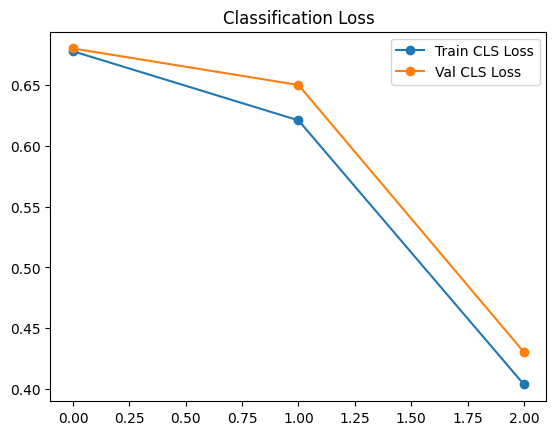

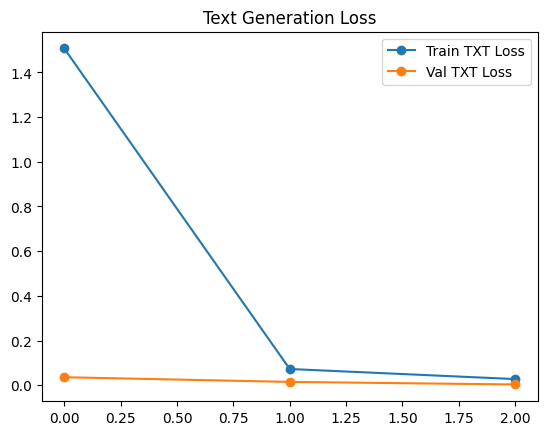


=== TEST PHASE ===


Testing:   0%|          | 0/4 [00:00<?, ?it/s]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.19370335340499878
Projected Features Std: 0.38380712270736694
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 1]), Max=50256, Min=50256
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 2]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 3]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 4]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 5]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 6]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 7]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 8]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 9]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 10]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 11]), Max=50256, Min=16
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 

Testing:  25%|██▌       | 1/4 [00:11<00:34, 11.63s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.19395099580287933
Projected Features Std: 0.3758299946784973
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 1]), Max=50256, Min=50256
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 2]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 3]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 4]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 5]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 6]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 7]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 8]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 9]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 10]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 11]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 1

Testing:  50%|█████     | 2/4 [00:23<00:23, 11.75s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.20670615136623383
Projected Features Std: 0.41127970814704895
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 1]), Max=50256, Min=50256
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 2]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 3]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 4]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 5]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 6]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 7]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 8]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 9]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 10]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 11]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([16, 

Testing:  75%|███████▌  | 3/4 [00:35<00:11, 11.69s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.1888986974954605
Projected Features Std: 0.36847156286239624
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 1]), Max=50256, Min=50256
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 2]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 3]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 4]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 5]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 6]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 7]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 8]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 9]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 10]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 11]), Max=50256, Min=58
🚨 Passing input_ids to GPT-2: Shape=torch.Size([7, 12]), Max=502

Test Classification Accuracy: 0.6545
Test BLEU:     0.0000
Test ROUGE-L:  0.0040

=== Sample Reports ===

[Ground Truth]:
[ Finding ] 
no significant bony lesion on radiographs. 
 
[ Conclusion ] 
no significant bony lesion on radiographs. 
 
[ Recommend ]
[Generated]   :
[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[
--------------------------------------------------
[Ground Truth]:
[FINDING       ] joint space narrowing, erosions at Rt talonavicular joint, both MTP, PIP, 1st IP joint 
-> RA involvement
   no significant interval change   [CONCLUSION    ] joint space narrowing, erosions at Rt talonavicular joint, both MTP, PIP, 1st IP joint 
-> RA involvement
   no significant interval change   [RECOMMENDATION] -
[Generated]   :
[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[
--------------------------------------------------
[Ground Truth]:
[ Finding ] 
 
[ Conclusion ] 
no change or slightly progressed RA, both hands and feet 
Degenerative changes and oste

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import pickle
import random
import numpy as np
import os
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Metrics / Utilities
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------- STEP 1: PREPARE DATA -------------

# Load GPT2 tokenizer and add a distinct BOS token if not present
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.bos_token is None:
    tokenizer.bos_token = "<BOS>"
    tokenizer.add_special_tokens({"bos_token": "<BOS>"})
# GPT2 doesn't have an official pad token, so we alias the EOS token as pad
tokenizer.pad_token = tokenizer.eos_token

# Load dataset (replace with your actual pkl path)
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Classification classes
task_classes = ['ra', 'normal']

# Balance dataset
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())
balanced_data = []
for cls in task_classes:
    balanced_data.extend(random.sample(data_by_class[cls], min_class_count))

# Optionally, repeat for "data augmentation" if you wish
augmented_data = balanced_data * 2

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        # Ensure consistency for special tokens
        if self.tokenizer.bos_token is None:
            self.tokenizer.bos_token = "<BOS>"
            self.tokenizer.add_special_tokens({"bos_token": "<BOS>"})
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        # Patch images
        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(patch) for patch in patches[:34]]  # up to 34 patches
            patch_tensors = [self.patch_transform(p) for p in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)  # shape (34*3, 112, 112)
        else:
            combined_patches = torch.zeros(34*3, 112, 112)  # placeholder if no patches

        # Label
        label = 1 if entry['class'].lower() == task_classes[0] else 0

        # Report text
        report_text = entry['diagnosis'].replace('_x000D_', ' ').strip()
        encoded_report = self.tokenizer(
            report_text,
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        return (
            image,
            combined_patches,
            label,
            encoded_report['input_ids'].squeeze(),
            encoded_report['attention_mask'].squeeze()
        )

# Split train/val/test
full_dataset = FootDataset(augmented_data, train_transform, patch_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

# ------------- STEP 2: MODEL DEFINITION -------------

class TwoBranchWithGPT2(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchWithGPT2, self).__init__()

        # -- SWIN Models --
        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()

        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        # -- ResNet Models --
        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch  = models.resnet50(pretrained=pretrained)
        resnet_global.fc = nn.Identity()
        resnet_patch.fc  = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch  = resnet_patch

        # -- For converting channel dimension from 102 -> 3 for patches
        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)

        # -- Merge + project to GPT2 hidden size (768) --
        self.feature_attention = nn.Sequential(
            nn.Linear(5632, 768),  # 768 for GPT2
            nn.ReLU()
        )

        # -- Classification head --
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # -- GPT-2 with cross-attention --
        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt2_config)
        # Resize embeddings to account for additional special tokens (e.g., BOS)
        self.gpt2.resize_token_embeddings(len(tokenizer))

        # Initialize cross-attention layers (optional: may require further tuning)
        for name, param in self.gpt2.named_parameters():
            if 'crossattention' in name:
                param.data.normal_(mean=0.0, std=0.02)

    def encode_features(self, images, patches):
        """
        Encode images and patches into a single projected feature tensor
        of shape (batch_size, 768).
        """
        # (B, 34*3, 112, 112) -> upsample to (B, 102, 224, 224)
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        # Reduce to 3 channels
        patches_reduced = self.patch_channel_reduction(patches_resized)

        # -- SWIN features --
        swin_global_features = self.swin_global.forward_features(images).mean(dim=[1, 2])   # (B, 768)
        swin_patch_features  = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])

        # -- ResNet features --
        resnet_global_features = self.resnet_global(images)           # (B, 2048)
        resnet_patch_features  = self.resnet_patch(patches_reduced)   # (B, 2048)

        # Merge features from all branches
        combined_features = torch.cat([
            swin_global_features,
            swin_patch_features,
            resnet_global_features,
            resnet_patch_features
        ], dim=1)  # (B, 768+768+2048+2048 = 5632)

        # Project to GPT2 hidden size (768)
        projected_features = self.feature_attention(combined_features) # (B, 768)
        return projected_features

    def forward(self, images, patches, input_ids=None, attention_mask=None):
        """
        Forward pass for:
          - Classification
          - (Optional) Teacher-forced text generation if input_ids is provided
        """
        # 1) Encode image and patch features
        projected_features = self.encode_features(images, patches)

        # 2) Classification branch
        cls_output = self.classifier(projected_features)  # shape (B, 1)

        # 3) Text generation with teacher forcing
        if input_ids is not None:
            # Pass the fixed context without expanding across sequence length
            encoder_hidden_states = projected_features.unsqueeze(1)  # shape (B, 1, 768)
            gpt_outputs = self.gpt2(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_hidden_states
            )
            return cls_output, gpt_outputs.logits
        else:
            # Only classification is required
            return cls_output

    def generate_reports(self, projected_features, tokenizer, max_length=50, do_sample=True):
        """
        Generate free-form text using the image features alone.
        Uses the fixed encoder context (without expanding to match sequence length)
        and a distinct BOS token to start the generation.
        """
        device = projected_features.device
        batch_size = projected_features.size(0)

        bos_id = tokenizer.bos_token_id  # Use the defined BOS token
        eos_id = tokenizer.eos_token_id
        vocab_size = tokenizer.vocab_size  

        print(f"GPT-2 Vocabulary Size: {vocab_size}")
        print("Projected Features Mean:", projected_features.mean().item())
        print("Projected Features Std:", projected_features.std().item())

        # Start generation with the BOS token for each sequence
        generated = [[bos_id] for _ in range(batch_size)]
        input_ids = torch.tensor(generated, device=device, dtype=torch.int64)

        if input_ids.numel() == 0:
            print("Error: input_ids is empty!")
            return [""] * batch_size

        temperature = 0.7  # Temperature for sampling

        # Use a fixed encoder hidden state from projected features (context length = 1)
        encoder_hidden_states = projected_features.unsqueeze(1)  # shape (B, 1, 768)

        for _ in range(max_length):
            # Ensure token IDs are within the valid range
            input_ids = torch.clamp(input_ids, min=0, max=vocab_size - 1)
            print(f"🚨 Passing input_ids to GPT-2: Shape={input_ids.shape}, Max={input_ids.max().item()}, Min={input_ids.min().item()}")

            outputs = self.gpt2(
                input_ids=input_ids,
                encoder_hidden_states=encoder_hidden_states,
                use_cache=False
            )
            logits = outputs.logits
            next_token_logits = logits[:, -1, :] / temperature  # Apply temperature scaling

            if do_sample:
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            # Clamp generated token IDs to valid range
            next_token[next_token >= vocab_size] = eos_id  
            next_token[next_token < 0] = bos_id  

            input_ids = torch.cat([input_ids, next_token], dim=1)

            # Optionally, stop if all sequences have generated the EOS token
            if all(t.item() == eos_id for t in next_token):
                break

        generated_texts = [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in input_ids]
        return generated_texts

# ------------- STEP 3: TRAINING SETUP -------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchWithGPT2(pretrained=True).to(device)

criterion_cls = nn.BCELoss()
criterion_txt = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def evaluate(model, dataloader):
    """
    Evaluate both classification and teacher-forced text generation.
    Returns average classification loss, text generation loss, and classification accuracy.
    """
    model.eval()
    total_loss_cls = 0.0
    total_loss_txt = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, patches, labels, input_ids, attention_mask in dataloader:
            images = images.to(device)
            patches = patches.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
            loss_cls = criterion_cls(cls_outputs, labels)
            loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

            total_loss_cls += loss_cls.item()
            total_loss_txt += loss_txt.item()

            preds = (cls_outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss_cls = total_loss_cls / len(dataloader)
    avg_loss_txt = total_loss_txt / len(dataloader)
    accuracy = correct / total

    return avg_loss_cls, avg_loss_txt, accuracy

# Training Loop
num_epochs = 3  # Note: Increase the number of epochs for better convergence
train_losses_cls, val_losses_cls = [], []
train_losses_txt, val_losses_txt = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss_cls = 0.0
    running_loss_txt = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch {epoch+1}/{num_epochs} ...")
    train_bar = tqdm(train_loader, desc="Train", leave=False)
    for images, patches, labels, input_ids, attention_mask in train_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).unsqueeze(1).float()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        optimizer.zero_grad()
        cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
        loss_cls = criterion_cls(cls_outputs, labels)
        loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

        loss = loss_cls + loss_txt
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss_cls += loss_cls.item()
        running_loss_txt += loss_txt.item()

        preds = (cls_outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix({
            "loss_cls": f"{loss_cls.item():.3f}",
            "loss_txt": f"{loss_txt.item():.3f}"
        })

    # Evaluate on validation set
    train_loss_cls = running_loss_cls / len(train_loader)
    train_loss_txt = running_loss_txt / len(train_loader)
    train_acc = correct_train / total_train

    val_loss_cls, val_loss_txt, val_acc = evaluate(model, val_loader)

    train_losses_cls.append(train_loss_cls)
    val_losses_cls.append(val_loss_cls)
    train_losses_txt.append(train_loss_txt)
    val_losses_txt.append(val_loss_txt)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: CLS={train_loss_cls:.4f}, TXT={train_loss_txt:.4f}, Acc={train_acc:.4f}")
    print(f"  Val   Loss: CLS={val_loss_cls:.4f}, TXT={val_loss_txt:.4f}, Acc={val_acc:.4f}")

print("Training Complete!")

# Optional: Quick Plots of Classification / Text Loss
plt.figure()
plt.plot(train_losses_cls, label="Train CLS Loss", marker='o')
plt.plot(val_losses_cls, label="Val CLS Loss", marker='o')
plt.legend()
plt.title("Classification Loss")

plt.figure()
plt.plot(train_losses_txt, label="Train TXT Loss", marker='o')
plt.plot(val_losses_txt, label="Val TXT Loss", marker='o')
plt.legend()
plt.title("Text Generation Loss")
plt.show()

# ------------- STEP 4: TEST / INFERENCE -------------

print("\n=== TEST PHASE ===")

model.eval()
test_bar = tqdm(test_loader, desc="Testing", leave=False)

all_preds = []
all_labels = []

all_generated_texts = []
all_ground_truth_texts = []

with torch.no_grad():
    for images, patches, labels, input_ids, attention_mask in test_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).float()

        # 1) Classification (no teacher forcing)
        cls_outputs = model(images, patches, input_ids=None)
        preds = (cls_outputs >= 0.5).long().squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 2) Generate free-form text from image features alone
        projected_features = model.encode_features(images, patches)
        gen_texts = model.generate_reports(
            projected_features,
            tokenizer=tokenizer,
            max_length=60,
            do_sample=True  # Set to True for sampling-based generation
        )
        all_generated_texts.extend(gen_texts)

        # 3) Save ground truth texts for evaluation
        for iids in input_ids:
            ref = tokenizer.decode(iids, skip_special_tokens=True)
            all_ground_truth_texts.append(ref)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean()
print(f"Test Classification Accuracy: {accuracy:.4f}")

def evaluate_generated_texts(ground_truth_texts, generated_texts):
    """
    Evaluate BLEU and ROUGE-L scores for lists of ground truth and generated texts.
    If a generated text is empty, a score of 0 is assigned.
    """
    rouge = Rouge()
    bleu_scores = []
    rouge_l_scores = []

    for ref_text, gen_text in zip(ground_truth_texts, generated_texts):
        # If generated text is empty, assign a score of 0
        if not gen_text.strip():
            bleu_scores.append(0)
            rouge_l_scores.append(0)
            continue

        ref_tokens = ref_text.split()
        gen_tokens = gen_text.split()

        # Compute BLEU score (you may add smoothing if needed)
        bleu = sentence_bleu([ref_tokens], gen_tokens)
        bleu_scores.append(bleu)

        # Compute ROUGE-L score; assign 0 if computation fails
        try:
            scores = rouge.get_scores(gen_text, ref_text)
            rouge_l_scores.append(scores[0]["rouge-l"]["f"])
        except ValueError:
            rouge_l_scores.append(0)

    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0
    avg_rouge = np.mean(rouge_l_scores) if rouge_l_scores else 0
    return avg_bleu, avg_rouge

avg_bleu, avg_rouge = evaluate_generated_texts(all_ground_truth_texts, all_generated_texts)

print(f"Test BLEU:     {avg_bleu:.4f}")
print(f"Test ROUGE-L:  {avg_rouge:.4f}")

# Print sample outputs for comparison
print("\n=== Sample Reports ===\n")
for i in range(3):
    print(f"[Ground Truth]:\n{all_ground_truth_texts[i]}")
    print(f"[Generated]   :\n{all_generated_texts[i]}")
    print("--------------------------------------------------")


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Epoch 1/2 ...


Epoch 1:
  Train Loss: CLS=0.6631, TXT=2.0294, Acc=0.5618
  Val   Loss: CLS=0.5635, TXT=0.0767, Acc=0.7963
Epoch 2/2 ...


Epoch 2:
  Train Loss: CLS=0.4672, TXT=0.0975, Acc=0.8446
  Val   Loss: CLS=0.3814, TXT=0.0081, Acc=0.9074
Training Complete!


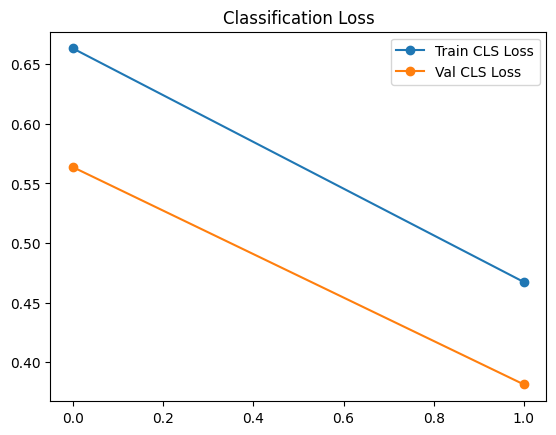

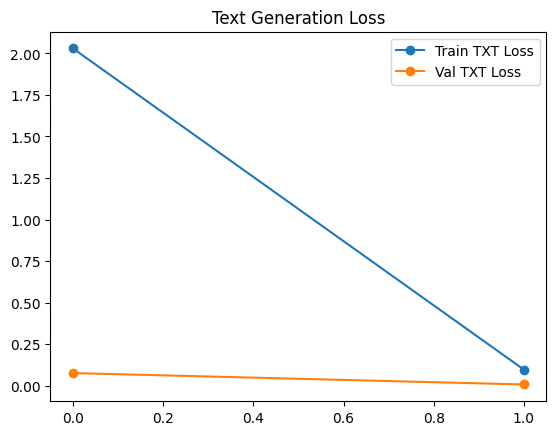


=== TEST PHASE ===


Testing:   0%|          | 0/4 [00:00<?, ?it/s]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.3115178048610687
Projected Features Std: 0.5571224093437195


Testing:  25%|██▌       | 1/4 [00:12<00:36, 12.11s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.3186721205711365
Projected Features Std: 0.5803834795951843


Testing:  50%|█████     | 2/4 [00:24<00:24, 12.24s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.3112775385379791
Projected Features Std: 0.5567835569381714


Testing:  75%|███████▌  | 3/4 [00:36<00:12, 12.33s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.3271929621696472
Projected Features Std: 0.5895465612411499


Test Classification Accuracy: 0.7818
Test BLEU:     0.0000
Test ROUGE-L:  0.0000

=== Sample Reports ===

[Ground Truth]:
[ Finding ] 
no significant bony lesion on radiographs. 
 
[ Conclusion ] 
no significant bony lesion on radiographs. 
 
[ Recommend ]
[Generated]   :
The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The The
--------------------------------------------------
[Ground Truth]:
[ Finding ] 
both feet, RA 
 
[ Conclusion ] 
both feet, RA 
 
[ Recommend ]
[Generated]   :
[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[ decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre decre
--------------------------------------------------
[Ground Truth]:
[ Finding ] 
 
[ Diagnosis ] 
Rt. knee joint effusion 
Lt. accessory navic

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import pickle
import random
import numpy as np
import os
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Metrics / Utilities
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------- STEP 1: PREPARE DATA -------------

# Load GPT2 tokenizer and add a distinct BOS token if needed
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.bos_token is None:
    tokenizer.bos_token = "<BOS>"
    tokenizer.add_special_tokens({"bos_token": "<BOS>"})
# GPT2 doesn't have an official pad token, so we alias the EOS token as pad
tokenizer.pad_token = tokenizer.eos_token

# Load dataset (replace with your actual pkl path)
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Classification classes
task_classes = ['ra', 'normal']

# Balance dataset
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())
balanced_data = []
for cls in task_classes:
    balanced_data.extend(random.sample(data_by_class[cls], min_class_count))

# Optionally, repeat for "data augmentation" if desired
augmented_data = balanced_data * 2

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        if self.tokenizer.bos_token is None:
            self.tokenizer.bos_token = "<BOS>"
            self.tokenizer.add_special_tokens({"bos_token": "<BOS>"})
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        # Process patch images
        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(patch) for patch in patches[:34]]  # up to 34 patches
            patch_tensors = [self.patch_transform(p) for p in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)  # shape (34*3, 112, 112)
        else:
            combined_patches = torch.zeros(34*3, 112, 112)  # placeholder if no patches

        # Label: 1 for the first class, 0 for the other
        label = 1 if entry['class'].lower() == task_classes[0] else 0

        # Process report text
        report_text = entry['diagnosis'].replace('_x000D_', ' ').strip()
        encoded_report = self.tokenizer(
            report_text,
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        return (
            image,
            combined_patches,
            label,
            encoded_report['input_ids'].squeeze(),
            encoded_report['attention_mask'].squeeze()
        )

# Split into train/validation/test datasets
full_dataset = FootDataset(augmented_data, train_transform, patch_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

# ------------- STEP 2: MODEL DEFINITION -------------

class TwoBranchWithGPT2(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchWithGPT2, self).__init__()

        # -- SWIN Models --
        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        # -- ResNet Models --
        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch  = models.resnet50(pretrained=pretrained)
        resnet_global.fc = nn.Identity()
        resnet_patch.fc  = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch  = resnet_patch

        # -- Convert patch channels from 102 -> 3
        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)

        # -- Merge & project features to GPT2 hidden size (768) --
        self.feature_attention = nn.Sequential(
            nn.Linear(5632, 768),
            nn.ReLU()
        )

        # -- Classification head --
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # -- GPT-2 with cross-attention --
        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt2_config)
        self.gpt2.resize_token_embeddings(len(tokenizer))

        # Initialize cross-attention layers (they are newly added and need tuning)
        for name, param in self.gpt2.named_parameters():
            if 'crossattention' in name:
                param.data.normal_(mean=0.0, std=0.02)

        # -- Prefix Projector --
        # This module projects the 768-dim image feature into a sequence of tokens (prefix)
        # that the GPT-2 cross-attention can attend to.
        self.prefix_length = 10  # You can experiment with different prefix lengths.
        self.prefix_projector = nn.Linear(768, 768 * self.prefix_length)

    def encode_features(self, images, patches):
        # Upsample patches to the same size as images
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        patches_reduced = self.patch_channel_reduction(patches_resized)

        # Extract features from SWIN models
        swin_global_features = self.swin_global.forward_features(images).mean(dim=[1, 2])
        swin_patch_features  = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])

        # Extract features from ResNet models
        resnet_global_features = self.resnet_global(images)
        resnet_patch_features  = self.resnet_patch(patches_reduced)

        # Concatenate all features and project to 768 dimensions
        combined_features = torch.cat([
            swin_global_features,
            swin_patch_features,
            resnet_global_features,
            resnet_patch_features
        ], dim=1)  # Shape: (B, 5632)
        projected_features = self.feature_attention(combined_features)  # Shape: (B, 768)
        return projected_features

    def forward(self, images, patches, input_ids=None, attention_mask=None):
        projected_features = self.encode_features(images, patches)
        cls_output = self.classifier(projected_features)

        # If teacher forcing is used, pass text tokens and cross-attention context
        if input_ids is not None:
            batch_size = projected_features.size(0)
            # Create a prefix context from image features
            encoder_hidden_states = self.prefix_projector(projected_features)
            encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)
            gpt_outputs = self.gpt2(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_hidden_states
            )
            return cls_output, gpt_outputs.logits
        else:
            return cls_output

    def generate_reports(self, projected_features, tokenizer, max_length=50, do_sample=True):
        """
        Generate free-form text from image features.
        Here we use the prefix projector to create a multi-token context.
        """
        device = projected_features.device
        batch_size = projected_features.size(0)

        bos_id = tokenizer.bos_token_id  # distinct BOS token
        eos_id = tokenizer.eos_token_id
        vocab_size = tokenizer.vocab_size

        print(f"GPT-2 Vocabulary Size: {vocab_size}")
        print("Projected Features Mean:", projected_features.mean().item())
        print("Projected Features Std:", projected_features.std().item())

        # Initialize generated sequences with BOS
        generated = [[bos_id] for _ in range(batch_size)]
        input_ids = torch.tensor(generated, device=device, dtype=torch.int64)

        temperature = 0.7

        # Create prefix context from image features
        encoder_hidden_states = self.prefix_projector(projected_features)
        encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)

        for _ in range(max_length):
            input_ids = torch.clamp(input_ids, min=0, max=vocab_size - 1)
            outputs = self.gpt2(
                input_ids=input_ids,
                encoder_hidden_states=encoder_hidden_states,
                use_cache=False
            )
            logits = outputs.logits
            next_token_logits = logits[:, -1, :] / temperature

            if do_sample:
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            next_token[next_token >= vocab_size] = eos_id
            next_token[next_token < 0] = bos_id

            input_ids = torch.cat([input_ids, next_token], dim=1)

            # Stop if all sequences have generated the EOS token
            if all(t.item() == eos_id for t in next_token):
                break

        generated_texts = [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in input_ids]
        return generated_texts

# ------------- STEP 3: TRAINING SETUP -------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchWithGPT2(pretrained=True).to(device)

criterion_cls = nn.BCELoss()
criterion_txt = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def evaluate(model, dataloader):
    """
    Evaluate classification and teacher-forced text generation.
    Returns average classification loss, text generation loss, and accuracy.
    """
    model.eval()
    total_loss_cls = 0.0
    total_loss_txt = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, patches, labels, input_ids, attention_mask in dataloader:
            images = images.to(device)
            patches = patches.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
            loss_cls = criterion_cls(cls_outputs, labels)
            loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

            total_loss_cls += loss_cls.item()
            total_loss_txt += loss_txt.item()

            preds = (cls_outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss_cls = total_loss_cls / len(dataloader)
    avg_loss_txt = total_loss_txt / len(dataloader)
    accuracy = correct / total

    return avg_loss_cls, avg_loss_txt, accuracy

# Training Loop (Note: Increase num_epochs for better convergence)
num_epochs = 2
train_losses_cls, val_losses_cls = [], []
train_losses_txt, val_losses_txt = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss_cls = 0.0
    running_loss_txt = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch {epoch+1}/{num_epochs} ...")
    train_bar = tqdm(train_loader, desc="Train", leave=False)
    for images, patches, labels, input_ids, attention_mask in train_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).unsqueeze(1).float()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        optimizer.zero_grad()
        cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
        loss_cls = criterion_cls(cls_outputs, labels)
        loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

        loss = loss_cls + loss_txt
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss_cls += loss_cls.item()
        running_loss_txt += loss_txt.item()

        preds = (cls_outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix({
            "loss_cls": f"{loss_cls.item():.3f}",
            "loss_txt": f"{loss_txt.item():.3f}"
        })

    train_loss_cls = running_loss_cls / len(train_loader)
    train_loss_txt = running_loss_txt / len(train_loader)
    train_acc = correct_train / total_train

    val_loss_cls, val_loss_txt, val_acc = evaluate(model, val_loader)

    train_losses_cls.append(train_loss_cls)
    val_losses_cls.append(val_loss_cls)
    train_losses_txt.append(train_loss_txt)
    val_losses_txt.append(val_loss_txt)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: CLS={train_loss_cls:.4f}, TXT={train_loss_txt:.4f}, Acc={train_acc:.4f}")
    print(f"  Val   Loss: CLS={val_loss_cls:.4f}, TXT={val_loss_txt:.4f}, Acc={val_acc:.4f}")

print("Training Complete!")

# Optional: Quick Plots of Losses
plt.figure()
plt.plot(train_losses_cls, label="Train CLS Loss", marker='o')
plt.plot(val_losses_cls, label="Val CLS Loss", marker='o')
plt.legend()
plt.title("Classification Loss")

plt.figure()
plt.plot(train_losses_txt, label="Train TXT Loss", marker='o')
plt.plot(val_losses_txt, label="Val TXT Loss", marker='o')
plt.legend()
plt.title("Text Generation Loss")
plt.show()

# ------------- STEP 4: TEST / INFERENCE -------------

print("\n=== TEST PHASE ===")

model.eval()
test_bar = tqdm(test_loader, desc="Testing", leave=False)

all_preds = []
all_labels = []
all_generated_texts = []
all_ground_truth_texts = []

with torch.no_grad():
    for images, patches, labels, input_ids, attention_mask in test_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).float()

        # 1) Classification (without teacher forcing)
        cls_outputs = model(images, patches, input_ids=None)
        preds = (cls_outputs >= 0.5).long().squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 2) Generate free-form text from image features
        projected_features = model.encode_features(images, patches)
        gen_texts = model.generate_reports(
            projected_features,
            tokenizer=tokenizer,
            max_length=60,
            do_sample=True  # Use sampling-based generation
        )
        all_generated_texts.extend(gen_texts)

        # 3) Collect ground truth texts for evaluation
        for iids in input_ids:
            ref = tokenizer.decode(iids, skip_special_tokens=True)
            all_ground_truth_texts.append(ref)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean()
print(f"Test Classification Accuracy: {accuracy:.4f}")

def evaluate_generated_texts(ground_truth_texts, generated_texts):
    """
    Evaluate generated texts using BLEU and ROUGE-L scores.
    If a generated text is empty, assign a score of 0.
    """
    rouge = Rouge()
    bleu_scores = []
    rouge_l_scores = []

    for ref_text, gen_text in zip(ground_truth_texts, generated_texts):
        if not gen_text.strip():
            bleu_scores.append(0)
            rouge_l_scores.append(0)
            continue

        ref_tokens = ref_text.split()
        gen_tokens = gen_text.split()

        bleu = sentence_bleu([ref_tokens], gen_tokens)
        bleu_scores.append(bleu)

        try:
            scores = rouge.get_scores(gen_text, ref_text)
            rouge_l_scores.append(scores[0]["rouge-l"]["f"])
        except ValueError:
            rouge_l_scores.append(0)

    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0
    avg_rouge = np.mean(rouge_l_scores) if rouge_l_scores else 0
    return avg_bleu, avg_rouge

avg_bleu, avg_rouge = evaluate_generated_texts(all_ground_truth_texts, all_generated_texts)
print(f"Test BLEU:     {avg_bleu:.4f}")
print(f"Test ROUGE-L:  {avg_rouge:.4f}")

# Print a few sample outputs for qualitative inspection
print("\n=== Sample Reports ===\n")
for i in range(3):
    print(f"[Ground Truth]:\n{all_ground_truth_texts[i]}")
    print(f"[Generated]   :\n{all_generated_texts[i]}")
    print("--------------------------------------------------")


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Epoch 1/5 ...


Epoch 1:
  Train Loss: CLS=0.6667, TXT=1.8354, Acc=0.5657
  Val   Loss: CLS=0.6047, TXT=0.0777, Acc=0.8519
Epoch 2/5 ...


Epoch 2:
  Train Loss: CLS=0.4275, TXT=0.0880, Acc=0.9203
  Val   Loss: CLS=0.5619, TXT=0.0207, Acc=0.7037
Epoch 3/5 ...


Epoch 3:
  Train Loss: CLS=0.1515, TXT=0.0341, Acc=0.9721
  Val   Loss: CLS=0.2525, TXT=0.0037, Acc=0.9074
Epoch 4/5 ...


Epoch 4:
  Train Loss: CLS=0.1371, TXT=0.0163, Acc=0.9522
  Val   Loss: CLS=0.1856, TXT=0.0038, Acc=0.9444
Epoch 5/5 ...


Epoch 5:
  Train Loss: CLS=0.0336, TXT=0.0168, Acc=0.9960
  Val   Loss: CLS=0.1178, TXT=0.0025, Acc=0.9444
Training Complete!


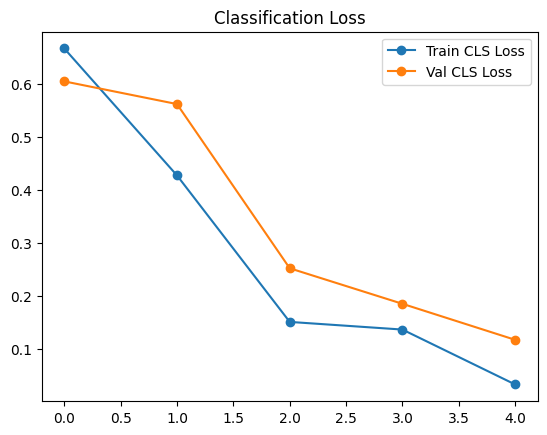

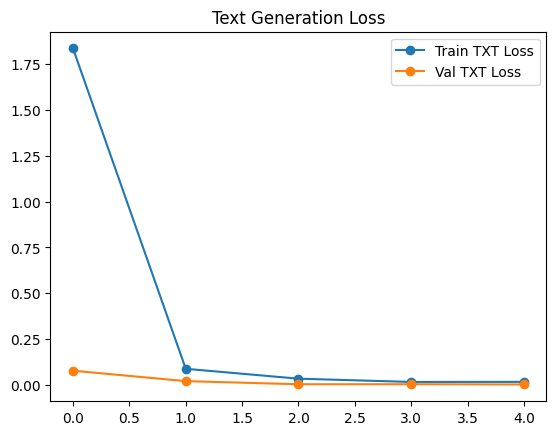


=== TEST PHASE ===


Testing:   0%|          | 0/4 [00:00<?, ?it/s]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.50008624792099
Projected Features Std: 0.9517598152160645


Testing:  25%|██▌       | 1/4 [00:13<00:39, 13.15s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.6241723895072937
Projected Features Std: 1.1461544036865234


Testing:  50%|█████     | 2/4 [00:26<00:26, 13.06s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.49274876713752747
Projected Features Std: 0.9881116151809692


Testing:  75%|███████▌  | 3/4 [00:39<00:13, 13.07s/it]

GPT-2 Vocabulary Size: 50257
Projected Features Mean: 0.5592606663703918
Projected Features Std: 1.01761794090271


Test Classification Accuracy: 0.9818
Test BLEU:     0.0000
Test ROUGE-L:  0.0000

=== Sample Reports ===

[Ground Truth]:
[ Finding ] 
diffuse osteopenia. 
Lt. Achilles tendon, postop. change. 
[ Conclusion ] 
diffuse osteopenia. 
Lt. Achilles tendon, postop. change. 
[ Recommend ]
[Generated]   :
[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[
--------------------------------------------------
[Ground Truth]:
[FINDING       ] -  [CONCLUSION    ] periarticular osteopenia, both MTP joint 
soft tissue swelling around Lt 5th MTP joint with suspicious erosion 
-> r/o RA involvement   [RECOMMENDATION] -
[Generated]   :
[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[
--------------------------------------------------
[Ground Truth]:
[ Finding ] 
No bony abnormality 
 
[ Diagnosis ] 
No bony abnormality 
[ Recommend ]
[Generated]   :
[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[
--------------------------------------------------


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import pickle
import random
import numpy as np
import os
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Metrics / Utilities
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------- STEP 1: PREPARE DATA -------------

# Load GPT2 tokenizer and add a distinct BOS token if needed
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.bos_token is None:
    tokenizer.bos_token = "<BOS>"
    tokenizer.add_special_tokens({"bos_token": "<BOS>"})
# GPT2 doesn't have an official pad token, so we alias the EOS token as pad
tokenizer.pad_token = tokenizer.eos_token

# Load dataset (replace with your actual pkl path)
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Classification classes
task_classes = ['ra', 'normal']

# Balance dataset
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())
balanced_data = []
for cls in task_classes:
    balanced_data.extend(random.sample(data_by_class[cls], min_class_count))

# Optionally, repeat for "data augmentation" if desired
augmented_data = balanced_data * 2

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        if self.tokenizer.bos_token is None:
            self.tokenizer.bos_token = "<BOS>"
            self.tokenizer.add_special_tokens({"bos_token": "<BOS>"})
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        # Process patch images
        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(patch) for patch in patches[:34]]  # up to 34 patches
            patch_tensors = [self.patch_transform(p) for p in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)  # shape (34*3, 112, 112)
        else:
            combined_patches = torch.zeros(34*3, 112, 112)  # placeholder if no patches

        # Label: 1 for the first class, 0 for the other
        label = 1 if entry['class'].lower() == task_classes[0] else 0

        # Process report text
        report_text = entry['diagnosis'].replace('_x000D_', ' ').strip()
        encoded_report = self.tokenizer(
            report_text,
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        return (
            image,
            combined_patches,
            label,
            encoded_report['input_ids'].squeeze(),
            encoded_report['attention_mask'].squeeze()
        )

# Split train/val/test
full_dataset = FootDataset(augmented_data, train_transform, patch_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

# ------------- STEP 2: MODEL DEFINITION -------------

class TwoBranchWithGPT2(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchWithGPT2, self).__init__()

        # -- SWIN Models --
        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        # -- ResNet Models --
        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch  = models.resnet50(pretrained=pretrained)
        resnet_global.fc = nn.Identity()
        resnet_patch.fc  = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch  = resnet_patch

        # -- Convert patch channels from 102 -> 3
        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)

        # -- Merge & project features to GPT2 hidden size (768) --
        self.feature_attention = nn.Sequential(
            nn.Linear(5632, 768),
            nn.ReLU()
        )

        # -- Classification head --
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # -- GPT-2 with cross-attention --
        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt2_config)
        self.gpt2.resize_token_embeddings(len(tokenizer))
        # Initialize cross-attention layers
        for name, param in self.gpt2.named_parameters():
            if 'crossattention' in name:
                param.data.normal_(mean=0.0, std=0.02)

        # -- Prefix Projector --
        # This projects the 768-dim image feature into a sequence (prefix) of tokens.
        self.prefix_length = 10  # You can experiment with different lengths.
        self.prefix_projector = nn.Linear(768, 768 * self.prefix_length)

    def encode_features(self, images, patches):
        # Upsample patches to image size
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        patches_reduced = self.patch_channel_reduction(patches_resized)

        # Extract features from SWIN models
        swin_global_features = self.swin_global.forward_features(images).mean(dim=[1, 2])
        swin_patch_features  = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])

        # Extract features from ResNet models
        resnet_global_features = self.resnet_global(images)
        resnet_patch_features  = self.resnet_patch(patches_reduced)

        # Concatenate and project
        combined_features = torch.cat([
            swin_global_features,
            swin_patch_features,
            resnet_global_features,
            resnet_patch_features
        ], dim=1)  # (B, 5632)
        projected_features = self.feature_attention(combined_features)  # (B, 768)
        return projected_features

    def forward(self, images, patches, input_ids=None, attention_mask=None):
        projected_features = self.encode_features(images, patches)
        cls_output = self.classifier(projected_features)

        # If teacher forcing, use the prefix context for cross-attention
        if input_ids is not None:
            batch_size = projected_features.size(0)
            encoder_hidden_states = self.prefix_projector(projected_features)
            encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)
            gpt_outputs = self.gpt2(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_hidden_states
            )
            return cls_output, gpt_outputs.logits
        else:
            return cls_output

    def generate_reports(self, projected_features, tokenizer, max_length=50, do_sample=True, top_k=50, top_p=0.95, temperature=0.7):
        """
        Generate free-form text from image features using a learned prefix context.
        We use top-k and top-p filtering to improve diversity.
        """
        device = projected_features.device
        batch_size = projected_features.size(0)
        bos_id = tokenizer.bos_token_id
        eos_id = tokenizer.eos_token_id
        vocab_size = tokenizer.vocab_size

        print(f"GPT-2 Vocabulary Size: {vocab_size}")
        print("Projected Features Mean:", projected_features.mean().item())
        print("Projected Features Std:", projected_features.std().item())

        # Start with BOS token for each sequence
        generated = [[bos_id] for _ in range(batch_size)]
        input_ids = torch.tensor(generated, device=device, dtype=torch.long)

        # Create prefix context
        encoder_hidden_states = self.prefix_projector(projected_features)
        encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)

        # Helper function: top-k and top-p filtering for a single sample (1D logits)
        def top_k_top_p_filtering_single(logits, top_k=0, top_p=1.0, filter_value=-float('Inf')):
            # logits is a 1D tensor
            top_k = min(top_k, logits.size(-1))
            if top_k > 0:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][-1]
                logits[indices_to_remove] = filter_value
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Shift the indices to keep at least one token
                sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
                sorted_indices_to_remove[0] = 0
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[indices_to_remove] = filter_value
            return logits

        # Generation loop
        for _ in range(max_length):
            input_ids = torch.clamp(input_ids, min=0, max=vocab_size - 1)
            outputs = self.gpt2(
                input_ids=input_ids,
                encoder_hidden_states=encoder_hidden_states,
                use_cache=False
            )
            logits = outputs.logits  # (B, seq_len, vocab_size)
            next_token_logits = logits[:, -1, :] / temperature  # (B, vocab_size)

            # Apply top-k and top-p filtering for each example in the batch
            filtered_logits = []
            for logit in next_token_logits:
                filtered = top_k_top_p_filtering_single(logit.clone(), top_k=top_k, top_p=top_p)
                filtered_logits.append(filtered)
            filtered_logits = torch.stack(filtered_logits)  # (B, vocab_size)

            if do_sample:
                probs = F.softmax(filtered_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                next_token = torch.argmax(filtered_logits, dim=-1, keepdim=True)

            next_token[next_token >= vocab_size] = eos_id
            next_token[next_token < 0] = bos_id

            input_ids = torch.cat([input_ids, next_token], dim=1)

            # Stop if all sequences have generated EOS
            if all(t.item() == eos_id for t in next_token):
                break

        generated_texts = [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in input_ids]
        return generated_texts

# ------------- STEP 3: TRAINING SETUP -------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchWithGPT2(pretrained=True).to(device)

criterion_cls = nn.BCELoss()
criterion_txt = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def evaluate(model, dataloader):
    """
    Evaluate both classification and teacher-forced text generation.
    Returns average classification loss, text generation loss, and accuracy.
    """
    model.eval()
    total_loss_cls = 0.0
    total_loss_txt = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, patches, labels, input_ids, attention_mask in dataloader:
            images = images.to(device)
            patches = patches.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
            loss_cls = criterion_cls(cls_outputs, labels)
            loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

            total_loss_cls += loss_cls.item()
            total_loss_txt += loss_txt.item()

            preds = (cls_outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss_cls = total_loss_cls / len(dataloader)
    avg_loss_txt = total_loss_txt / len(dataloader)
    accuracy = correct / total
    return avg_loss_cls, avg_loss_txt, accuracy

# Training Loop (increase num_epochs as needed)
num_epochs = 5
train_losses_cls, val_losses_cls = [], []
train_losses_txt, val_losses_txt = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss_cls = 0.0
    running_loss_txt = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch {epoch+1}/{num_epochs} ...")
    train_bar = tqdm(train_loader, desc="Train", leave=False)
    for images, patches, labels, input_ids, attention_mask in train_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).unsqueeze(1).float()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        optimizer.zero_grad()
        cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
        loss_cls = criterion_cls(cls_outputs, labels)
        loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))
        loss = loss_cls + loss_txt
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss_cls += loss_cls.item()
        running_loss_txt += loss_txt.item()

        preds = (cls_outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix({
            "loss_cls": f"{loss_cls.item():.3f}",
            "loss_txt": f"{loss_txt.item():.3f}"
        })

    train_loss_cls = running_loss_cls / len(train_loader)
    train_loss_txt = running_loss_txt / len(train_loader)
    train_acc = correct_train / total_train

    val_loss_cls, val_loss_txt, val_acc = evaluate(model, val_loader)
    train_losses_cls.append(train_loss_cls)
    val_losses_cls.append(val_loss_cls)
    train_losses_txt.append(train_loss_txt)
    val_losses_txt.append(val_loss_txt)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: CLS={train_loss_cls:.4f}, TXT={train_loss_txt:.4f}, Acc={train_acc:.4f}")
    print(f"  Val   Loss: CLS={val_loss_cls:.4f}, TXT={val_loss_txt:.4f}, Acc={val_acc:.4f}")

print("Training Complete!")

# Optional: Quick Plots of Losses
plt.figure()
plt.plot(train_losses_cls, label="Train CLS Loss", marker='o')
plt.plot(val_losses_cls, label="Val CLS Loss", marker='o')
plt.legend()
plt.title("Classification Loss")

plt.figure()
plt.plot(train_losses_txt, label="Train TXT Loss", marker='o')
plt.plot(val_losses_txt, label="Val TXT Loss", marker='o')
plt.legend()
plt.title("Text Generation Loss")
plt.show()

# ------------- STEP 4: TEST / INFERENCE -------------

print("\n=== TEST PHASE ===")
model.eval()
test_bar = tqdm(test_loader, desc="Testing", leave=False)

all_preds = []
all_labels = []
all_generated_texts = []
all_ground_truth_texts = []

with torch.no_grad():
    for images, patches, labels, input_ids, attention_mask in test_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).float()

        # 1) Classification (without teacher forcing)
        cls_outputs = model(images, patches, input_ids=None)
        preds = (cls_outputs >= 0.5).long().squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 2) Generate free-form text from image features
        projected_features = model.encode_features(images, patches)
        gen_texts = model.generate_reports(
            projected_features,
            tokenizer=tokenizer,
            max_length=60,
            do_sample=True,   # Sampling-based generation
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )
        all_generated_texts.extend(gen_texts)

        # 3) Collect ground truth texts for evaluation
        for iids in input_ids:
            ref = tokenizer.decode(iids, skip_special_tokens=True)
            all_ground_truth_texts.append(ref)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean()
print(f"Test Classification Accuracy: {accuracy:.4f}")

def evaluate_generated_texts(ground_truth_texts, generated_texts):
    """
    Evaluate generated texts using BLEU and ROUGE-L scores.
    """
    rouge = Rouge()
    bleu_scores = []
    rouge_l_scores = []

    for ref_text, gen_text in zip(ground_truth_texts, generated_texts):
        if not gen_text.strip():
            bleu_scores.append(0)
            rouge_l_scores.append(0)
            continue
        ref_tokens = ref_text.split()
        gen_tokens = gen_text.split()
        bleu = sentence_bleu([ref_tokens], gen_tokens)
        bleu_scores.append(bleu)
        try:
            scores = rouge.get_scores(gen_text, ref_text)
            rouge_l_scores.append(scores[0]["rouge-l"]["f"])
        except ValueError:
            rouge_l_scores.append(0)
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0
    avg_rouge = np.mean(rouge_l_scores) if rouge_l_scores else 0
    return avg_bleu, avg_rouge

avg_bleu, avg_rouge = evaluate_generated_texts(all_ground_truth_texts, all_generated_texts)
print(f"Test BLEU:     {avg_bleu:.4f}")
print(f"Test ROUGE-L:  {avg_rouge:.4f}")

# Print a few sample outputs for qualitative inspection
print("\n=== Sample Reports ===\n")
for i in range(3):
    print(f"[Ground Truth]:\n{all_ground_truth_texts[i]}")
    print(f"[Generated]   :\n{all_generated_texts[i]}")
    print("--------------------------------------------------")


/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.l

Epoch 1/2 ...


Epoch 1:
  Train Loss: CLS=0.6935, TXT=2.2392, Acc=0.4940
  Val   Loss: CLS=0.6959, TXT=1.1742, Acc=0.4074
Epoch 2/2 ...


Epoch 2:
  Train Loss: CLS=0.6910, TXT=0.8734, Acc=0.5259
  Val   Loss: CLS=0.6963, TXT=0.6209, Acc=0.4074
Training Complete!


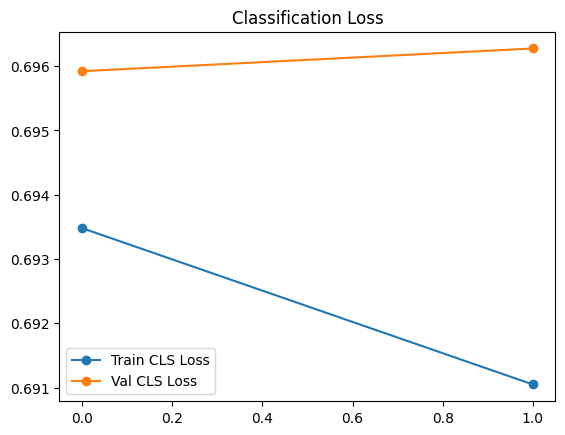

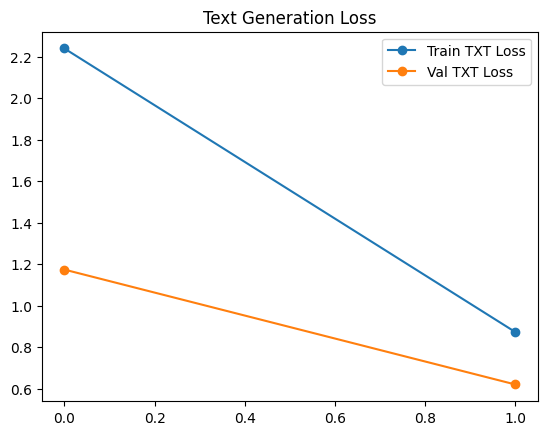


=== TEST PHASE ===


Testing:  75%|███████▌  | 3/4 [00:12<00:04,  4.28s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
                                                      

Test Classification Accuracy: 0.4727
Test BLEU:     0.0000
Test ROUGE-L:  0.0262

=== Sample Reports ===

[Ground Truth]:
[FINDING       ] newly noted bone erosion at Lt 5th MTP joint and possibly Lt 1st MTP joint 
-> RA involvement   [CONCLUSION    ] newly noted bone erosion at Lt 5th MTP joint and possibly Lt 1st MTP joint 
-> RA involvement   [RECOMMENDATION] -
[Generated]   :

This is what you get for your money. And here are some great things to do with the cash! Check out our full list of amazing deals on brentpizza and all related sites, or check this post at www... - The website that runs B2B offers a unique experience
--------------------------------------------------
[Ground Truth]:
[FINDING       ] no significant bony abnormality  [CONCLUSION    ] no significant bony abnormality  [RECOMMENDATION] -
[Generated]   :

A new study of the incidence and correlates between mortality rates, prevalence and causes. The results are based on a large number (1) cohort with an estimated s

/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import pickle
import random
import numpy as np
import os
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Metrics / Utilities
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------- STEP 1: PREPARE DATA -------------
'''
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.bos_token is None:
    tokenizer.bos_token = "<BOS>"
    tokenizer.add_special_tokens({"bos_token": "<BOS>"})
# GPT2 doesn't have an official pad token, so we alias the EOS token as pad
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
'''

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 lacks a pad token, so use EOS
tokenizer.padding_side = "left"

# Load dataset (replace with your actual pkl path)
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Classification classes
task_classes = ['ra', 'normal']

# Balance dataset
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())
balanced_data = []
for cls in task_classes:
    balanced_data.extend(random.sample(data_by_class[cls], min_class_count))

# Optionally, repeat for "data augmentation" if desired
augmented_data = balanced_data * 2

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform, tokenizer):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform
        self.tokenizer = tokenizer
        if self.tokenizer.bos_token is None:
            self.tokenizer.bos_token = "<BOS>"
            self.tokenizer.add_special_tokens({"bos_token": "<BOS>"})
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        # Process patch images
        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(patch) for patch in patches[:34]]  # up to 34 patches
            patch_tensors = [self.patch_transform(p) for p in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)  # shape (34*3, 112, 112)
        else:
            combined_patches = torch.zeros(34*3, 112, 112)  # placeholder if no patches

        # Label: 1 for the first class, 0 for the other
        label = 1 if entry['class'].lower() == task_classes[0] else 0

        # Process report text
        report_text = entry['diagnosis'].replace('_x000D_', ' ').strip()
        encoded_report = self.tokenizer(
            report_text,
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        return (
            image,
            combined_patches,
            label,
            encoded_report['input_ids'].squeeze(),
            encoded_report['attention_mask'].squeeze()
        )

# Split train/val/test
full_dataset = FootDataset(augmented_data, train_transform, patch_transform, tokenizer)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

# ------------- STEP 2: MODEL DEFINITION -------------

class TwoBranchWithGPT2(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchWithGPT2, self).__init__()

        # -- SWIN Models --
        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        # -- ResNet Models --
        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch  = models.resnet50(pretrained=pretrained)
        resnet_global.fc = nn.Identity()
        resnet_patch.fc  = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch  = resnet_patch

        # -- Convert patch channels from 102 -> 3
        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)

        # -- Merge & project features to GPT2 hidden size (768) --
        self.feature_attention = nn.Sequential(
            nn.Linear(5632, 768),
            nn.ReLU()
        )

        # -- Classification head --
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # -- GPT-2 with cross-attention --
        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt2_config)
        self.gpt2.resize_token_embeddings(len(tokenizer))
        # Initialize cross-attention layers
        for name, param in self.gpt2.named_parameters():
            if 'crossattention' in name:
                param.data.normal_(mean=0.0, std=0.02)

        # -- Prefix Projector --
        # This projects the 768-dim image feature into a sequence (prefix) of tokens.
        self.prefix_length = 10  # You can experiment with different lengths.
        self.prefix_projector = nn.Linear(768, 768 * self.prefix_length)

    def encode_features(self, images, patches):
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        patches_reduced = self.patch_channel_reduction(patches_resized)

        swin_global_features = self.swin_global.forward_features(images).mean(dim=[1, 2])
        swin_patch_features = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])

        resnet_global_features = self.resnet_global(images)
        resnet_patch_features = self.resnet_patch(patches_reduced)

        combined_features = torch.cat([swin_global_features, swin_patch_features,
                                    resnet_global_features, resnet_patch_features], dim=1)

        projected_features = self.feature_attention(combined_features)

        # Normalize to prevent large variations
        projected_features = F.normalize(projected_features, dim=-1)

        return projected_features


    def forward(self, images, patches, input_ids=None, attention_mask=None):
        projected_features = self.encode_features(images, patches)
        cls_output = self.classifier(projected_features)

        # If teacher forcing, use the prefix context for cross-attention
        if input_ids is not None:
            batch_size = projected_features.size(0)
            encoder_hidden_states = self.prefix_projector(projected_features)
            encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)
            gpt_outputs = self.gpt2(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_hidden_states
            )
            return cls_output, gpt_outputs.logits
        else:
            return cls_output

    def generate_reports(self, projected_features, tokenizer, max_length=50, 
                        do_sample=True, top_k=50, top_p=0.95, temperature=0.7):
        device = projected_features.device
        batch_size = projected_features.size(0)
        bos_id = tokenizer.bos_token_id
        eos_id = tokenizer.eos_token_id

        # Normalize projected features before feeding into GPT-2
        projected_features = F.normalize(projected_features, dim=-1)

        # Convert features into prefix tokens
        encoder_hidden_states = self.prefix_projector(projected_features)
        encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)

        input_ids = torch.full((batch_size, 1), bos_id, device=device, dtype=torch.long)

        # Define correct attention mask
        encoder_attention_mask = torch.ones((batch_size, self.prefix_length), device=device, dtype=torch.long)

        generated_ids = self.gpt2.generate(
            input_ids=input_ids,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            max_length=max_length,
            do_sample=do_sample,
            top_k=top_k,
            top_p=top_p,
            temperature=temperature,
            repetition_penalty=1.2,
            bos_token_id=bos_id,
            eos_token_id=eos_id,
            pad_token_id=tokenizer.pad_token_id
        )

        generated_texts = [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in generated_ids]
        return generated_texts




# ------------- STEP 3: TRAINING SETUP -------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchWithGPT2(pretrained=True).to(device)

criterion_cls = nn.BCELoss()
criterion_txt = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Loss weighting hyperparameters
alpha = 0.5  # weight for classification loss
beta  = 1.0  # weight for text generation loss

def evaluate(model, dataloader):
    """
    Evaluate both classification and teacher-forced text generation.
    Returns average classification loss, text generation loss, and accuracy.
    """
    model.eval()
    total_loss_cls = 0.0
    total_loss_txt = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, patches, labels, input_ids, attention_mask in dataloader:
            images = images.to(device)
            patches = patches.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
            loss_cls = criterion_cls(cls_outputs, labels)
            loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

            total_loss_cls += loss_cls.item()
            total_loss_txt += loss_txt.item()

            preds = (cls_outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss_cls = total_loss_cls / len(dataloader)
    avg_loss_txt = total_loss_txt / len(dataloader)
    accuracy = correct / total
    return avg_loss_cls, avg_loss_txt, accuracy

# Training Loop (increase num_epochs as needed)
num_epochs = 2
train_losses_cls, val_losses_cls = [], []
train_losses_txt, val_losses_txt = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss_cls = 0.0
    running_loss_txt = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch {epoch+1}/{num_epochs} ...")
    train_bar = tqdm(train_loader, desc="Train", leave=False)
    for images, patches, labels, input_ids, attention_mask in train_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).unsqueeze(1).float()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        optimizer.zero_grad()
        cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
        loss_cls = criterion_cls(cls_outputs, labels)
        loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))
        loss = alpha * loss_cls + beta * loss_txt
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss_cls += loss_cls.item()
        running_loss_txt += loss_txt.item()

        preds = (cls_outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix({
            "loss_cls": f"{loss_cls.item():.3f}",
            "loss_txt": f"{loss_txt.item():.3f}"
        })

    train_loss_cls = running_loss_cls / len(train_loader)
    train_loss_txt = running_loss_txt / len(train_loader)
    train_acc = correct_train / total_train

    val_loss_cls, val_loss_txt, val_acc = evaluate(model, val_loader)
    train_losses_cls.append(train_loss_cls)
    val_losses_cls.append(val_loss_cls)
    train_losses_txt.append(train_loss_txt)
    val_losses_txt.append(val_loss_txt)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: CLS={train_loss_cls:.4f}, TXT={train_loss_txt:.4f}, Acc={train_acc:.4f}")
    print(f"  Val   Loss: CLS={val_loss_cls:.4f}, TXT={val_loss_txt:.4f}, Acc={val_acc:.4f}")

print("Training Complete!")

# Optional: Quick Plots of Losses
plt.figure()
plt.plot(train_losses_cls, label="Train CLS Loss", marker='o')
plt.plot(val_losses_cls, label="Val CLS Loss", marker='o')
plt.legend()
plt.title("Classification Loss")

plt.figure()
plt.plot(train_losses_txt, label="Train TXT Loss", marker='o')
plt.plot(val_losses_txt, label="Val TXT Loss", marker='o')
plt.legend()
plt.title("Text Generation Loss")
plt.show()

# ------------- STEP 4: TEST / INFERENCE -------------

print("\n=== TEST PHASE ===")
model.eval()
test_bar = tqdm(test_loader, desc="Testing", leave=False)

all_preds = []
all_labels = []
all_generated_texts = []
all_ground_truth_texts = []

with torch.no_grad():
    for images, patches, labels, input_ids, attention_mask in test_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).float()

        # 1) Classification (without teacher forcing)
        cls_outputs = model(images, patches, input_ids=None)
        preds = (cls_outputs >= 0.5).long().squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 2) Generate free-form text from image features
        projected_features = model.encode_features(images, patches)
        gen_texts = model.generate_reports(
            projected_features,
            tokenizer=tokenizer,
            max_length=60,
            do_sample=True,   # Sampling-based generation
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )
        all_generated_texts.extend(gen_texts)

        # 3) Collect ground truth texts for evaluation
        for iids in input_ids:
            ref = tokenizer.decode(iids, skip_special_tokens=True)
            all_ground_truth_texts.append(ref)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean()
print(f"Test Classification Accuracy: {accuracy:.4f}")

def evaluate_generated_texts(ground_truth_texts, generated_texts):
    """
    Evaluate generated texts using BLEU and ROUGE-L scores.
    """
    rouge = Rouge()
    bleu_scores = []
    rouge_l_scores = []

    for ref_text, gen_text in zip(ground_truth_texts, generated_texts):
        if not gen_text.strip():
            bleu_scores.append(0)
            rouge_l_scores.append(0)
            continue
        ref_tokens = ref_text.split()
        gen_tokens = gen_text.split()
        bleu = sentence_bleu([ref_tokens], gen_tokens)
        bleu_scores.append(bleu)
        try:
            scores = rouge.get_scores(gen_text, ref_text)
            rouge_l_scores.append(scores[0]["rouge-l"]["f"])
        except ValueError:
            rouge_l_scores.append(0)
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0
    avg_rouge = np.mean(rouge_l_scores) if rouge_l_scores else 0
    return avg_bleu, avg_rouge

avg_bleu, avg_rouge = evaluate_generated_texts(all_ground_truth_texts, all_generated_texts)
print(f"Test BLEU:     {avg_bleu:.4f}")
print(f"Test ROUGE-L:  {avg_rouge:.4f}")

# Print a few sample outputs for qualitative inspection
print("\n=== Sample Reports ===\n")
for i in range(3):
    print(f"[Ground Truth]:\n{all_ground_truth_texts[i]}")
    print(f"[Generated]   :\n{all_generated_texts[i]}")
    print("--------------------------------------------------")


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Epoch 1/5 ...


Epoch 1:
  Train Loss: CLS=0.6893, TXT=2.0399, Acc=0.5219
  Val   Loss: CLS=0.6906, TXT=0.8119, Acc=0.6667
Epoch 2/5 ...


Epoch 2:
  Train Loss: CLS=0.6749, TXT=0.7299, Acc=0.8566
  Val   Loss: CLS=0.6899, TXT=0.5044, Acc=0.5185
Epoch 3/5 ...


Epoch 3:
  Train Loss: CLS=0.6678, TXT=0.5837, Acc=0.7968
  Val   Loss: CLS=0.6929, TXT=0.9503, Acc=0.5000
Epoch 4/5 ...


Epoch 4:
  Train Loss: CLS=0.6782, TXT=1.0515, Acc=0.6096
  Val   Loss: CLS=0.6923, TXT=1.0536, Acc=0.5370
Epoch 5/5 ...


Epoch 5:
  Train Loss: CLS=0.6791, TXT=1.2453, Acc=0.6016
  Val   Loss: CLS=0.6949, TXT=1.7674, Acc=0.5000
Training Complete!


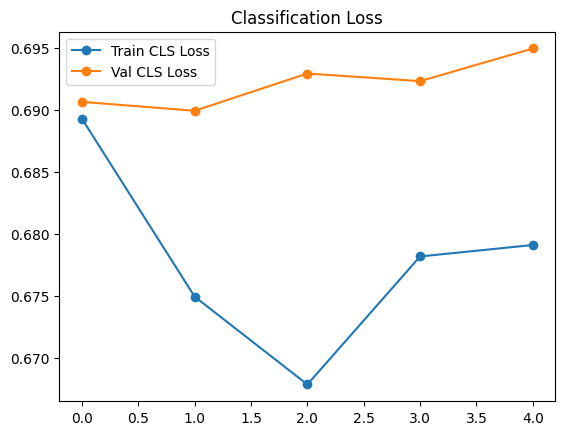

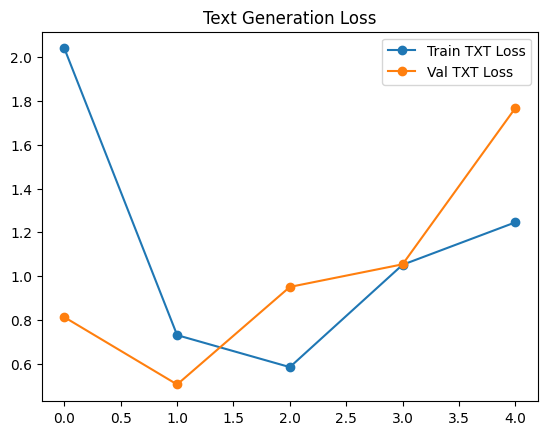


=== TEST PHASE ===


Testing:  75%|███████▌  | 3/4 [00:14<00:04,  4.68s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
                                                      

Test Classification Accuracy: 0.4000
Test BLEU:     0.0000
Test ROUGE-L:  0.0976

=== Sample Reports ===

[Ground Truth]:
[ Finding ] 
No bony abnormality. 
[ Diagnosis ] 
No bony abnormality. 
[ Recommend ]
[Generated]   :

t t . b er,ndthst atimnooidion ]both>-->->|OMERE[RSFK� ���� � KT�TPATION해�---------------� and/o /-------------------------------- > --- 52- M
--------------------------------------------------
[Ground Truth]:
[ Finding ] 
no significant bony lesion on radiographs. 
 
[ Conclusion ] 
no significant bony lesion on radiographs. 
 
[ Recommend ]
[Generated]   :

. ] > ------------------------------- ----------------------------->-->->==------------------------------------------------------------------------------------------------------------------------------------------------/OMFTPENDREthosistification-K[,indstnoeraloidnaroso ater andboth -ionaliaicularylusgumartere
--------------------------------------------------
[Ground Truth]:
[ Finding ] 
 
[ Diagnosis ] 
diff

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import pickle
import random
import numpy as np
import os
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------- STEP 1: PREPARE DATA -------------

# Initialize and fix tokenizer settings
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 lacks a pad token, use EOS
tokenizer.padding_side = "left"  # Prevents right-padding issues

# Load dataset (replace with your actual file path)
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Classification classes
task_classes = ['ra', 'normal']

# Balance dataset
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())
balanced_data = []
for cls in task_classes:
    balanced_data.extend(random.sample(data_by_class[cls], min_class_count))

# Data augmentation (Optional)
augmented_data = balanced_data * 2

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset Class
class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform, tokenizer):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        # Process patch images
        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(patch) for patch in patches[:34]]
            patch_tensors = [self.patch_transform(p) for p in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)
        else:
            combined_patches = torch.zeros(34*3, 112, 112)

        # Label
        label = 1 if entry['class'].lower() == task_classes[0] else 0

        # Process report text
        report_text = entry['diagnosis'].replace('_x000D_', ' ').strip()
        encoded_report = self.tokenizer(
            report_text,
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        return (
            image,
            combined_patches,
            label,
            encoded_report['input_ids'].squeeze(),
            encoded_report['attention_mask'].squeeze()
        )

# Create dataset splits
full_dataset = FootDataset(augmented_data, train_transform, patch_transform, tokenizer)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ------------- STEP 2: MODEL DEFINITION -------------

class TwoBranchWithGPT2(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchWithGPT2, self).__init__()

        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        resnet_global = models.resnet50(weights='IMAGENET1K_V1')
        resnet_patch = models.resnet50(weights='IMAGENET1K_V1')
        resnet_global.fc = nn.Identity()
        resnet_patch.fc = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch = resnet_patch

        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)
        self.feature_attention = nn.Sequential(nn.Linear(5632, 768), nn.ReLU())
        self.classifier = nn.Sequential(nn.Linear(768, 512), nn.ReLU(), nn.Linear(512, 1), nn.Sigmoid())

        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2", config=gpt2_config)
        self.gpt2.resize_token_embeddings(len(tokenizer))

        self.prefix_length = 10
        self.prefix_projector = nn.Linear(768, 768 * self.prefix_length)

    def encode_features(self, images, patches):
        # Resize patches to match input size (224x224)
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)

        # Reduce 102 channels -> 3 channels
        patches_reduced = self.patch_channel_reduction(patches_resized)

        # Extract features using SWIN
        swin_global_features = self.swin_global.forward_features(images).mean(dim=[1, 2])
        swin_patch_features = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])

        # Extract features using ResNet
        resnet_global_features = self.resnet_global(images)
        resnet_patch_features = self.resnet_patch(patches_reduced)  # Fix: Use reduced patches

        # Concatenate all features
        combined_features = torch.cat([
            swin_global_features, swin_patch_features, resnet_global_features, resnet_patch_features
        ], dim=1)

        projected_features = self.feature_attention(combined_features)
        
        return F.normalize(projected_features, dim=-1)


    def forward(self, images, patches, input_ids=None, attention_mask=None):
        projected_features = self.encode_features(images, patches)
        cls_output = self.classifier(projected_features)

        if input_ids is not None:
            encoder_hidden_states = self.prefix_projector(projected_features).view(projected_features.size(0), self.prefix_length, 768)
            gpt_outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask, encoder_hidden_states=encoder_hidden_states)
            return cls_output, gpt_outputs.logits
        return cls_output
    
    def generate_reports(self, projected_features, tokenizer, max_length=50, do_sample=True, top_k=50, top_p=0.95, temperature=0.7):
        """
        Generate free-form text reports from extracted image features.
        """
        device = projected_features.device
        batch_size = projected_features.size(0)
        bos_id = tokenizer.bos_token_id
        eos_id = tokenizer.eos_token_id

        # Normalize features before feeding into GPT-2
        projected_features = F.normalize(projected_features, dim=-1)

        # Convert features into prefix tokens
        encoder_hidden_states = self.prefix_projector(projected_features)
        encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)

        input_ids = torch.full((batch_size, 1), bos_id, device=device, dtype=torch.long)

        # Define correct attention mask
        encoder_attention_mask = torch.ones((batch_size, self.prefix_length), device=device, dtype=torch.long)

        generated_ids = self.gpt2.generate(
            input_ids=input_ids,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            max_length=max_length,
            do_sample=do_sample,
            top_k=top_k,
            top_p=top_p,
            temperature=temperature,
            repetition_penalty=1.2,
            bos_token_id=bos_id,
            eos_token_id=eos_id,
            pad_token_id=tokenizer.pad_token_id
        )

        generated_texts = [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in generated_ids]
        return generated_texts


# ------------- TRAINING & TESTING CODE -------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchWithGPT2(pretrained=True).to(device)

criterion_cls = nn.BCELoss()
criterion_txt = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

alpha = 0.5  # weight for classification loss
beta  = 1.0  # weight for text generation loss

def evaluate(model, dataloader):
    """
    Evaluate both classification and teacher-forced text generation.
    Returns average classification loss, text generation loss, and accuracy.
    """
    model.eval()
    total_loss_cls = 0.0
    total_loss_txt = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, patches, labels, input_ids, attention_mask in dataloader:
            images = images.to(device)
            patches = patches.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
            loss_cls = criterion_cls(cls_outputs, labels)
            loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))

            total_loss_cls += loss_cls.item()
            total_loss_txt += loss_txt.item()

            preds = (cls_outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss_cls = total_loss_cls / len(dataloader)
    avg_loss_txt = total_loss_txt / len(dataloader)
    accuracy = correct / total
    return avg_loss_cls, avg_loss_txt, accuracy

# Training Loop (increase num_epochs as needed)
num_epochs = 5
train_losses_cls, val_losses_cls = [], []
train_losses_txt, val_losses_txt = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss_cls = 0.0
    running_loss_txt = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch {epoch+1}/{num_epochs} ...")
    train_bar = tqdm(train_loader, desc="Train", leave=False)
    for images, patches, labels, input_ids, attention_mask in train_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).unsqueeze(1).float()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        optimizer.zero_grad()
        cls_outputs, gpt_outputs = model(images, patches, input_ids, attention_mask)
        loss_cls = criterion_cls(cls_outputs, labels)
        loss_txt = criterion_txt(gpt_outputs.reshape(-1, gpt_outputs.size(-1)), input_ids.reshape(-1))
        loss = alpha * loss_cls + beta * loss_txt
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss_cls += loss_cls.item()
        running_loss_txt += loss_txt.item()

        preds = (cls_outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix({
            "loss_cls": f"{loss_cls.item():.3f}",
            "loss_txt": f"{loss_txt.item():.3f}"
        })

    train_loss_cls = running_loss_cls / len(train_loader)
    train_loss_txt = running_loss_txt / len(train_loader)
    train_acc = correct_train / total_train

    val_loss_cls, val_loss_txt, val_acc = evaluate(model, val_loader)
    train_losses_cls.append(train_loss_cls)
    val_losses_cls.append(val_loss_cls)
    train_losses_txt.append(train_loss_txt)
    val_losses_txt.append(val_loss_txt)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: CLS={train_loss_cls:.4f}, TXT={train_loss_txt:.4f}, Acc={train_acc:.4f}")
    print(f"  Val   Loss: CLS={val_loss_cls:.4f}, TXT={val_loss_txt:.4f}, Acc={val_acc:.4f}")

print("Training Complete!")

# Optional: Quick Plots of Losses
plt.figure()
plt.plot(train_losses_cls, label="Train CLS Loss", marker='o')
plt.plot(val_losses_cls, label="Val CLS Loss", marker='o')
plt.legend()
plt.title("Classification Loss")

plt.figure()
plt.plot(train_losses_txt, label="Train TXT Loss", marker='o')
plt.plot(val_losses_txt, label="Val TXT Loss", marker='o')
plt.legend()
plt.title("Text Generation Loss")
plt.show()

# ------------- STEP 4: TEST / INFERENCE -------------

print("\n=== TEST PHASE ===")
model.eval()
test_bar = tqdm(test_loader, desc="Testing", leave=False)

all_preds = []
all_labels = []
all_generated_texts = []
all_ground_truth_texts = []

with torch.no_grad():
    for images, patches, labels, input_ids, attention_mask in test_bar:
        images = images.to(device)
        patches = patches.to(device)
        labels = labels.to(device).float()

        # 1) Classification (without teacher forcing)
        cls_outputs = model(images, patches, input_ids=None)
        preds = (cls_outputs >= 0.5).long().squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # 2) Generate free-form text from image features
        projected_features = model.encode_features(images, patches)
        gen_texts = model.generate_reports(
            projected_features,
            tokenizer=tokenizer,
            max_length=60,
            do_sample=True,   # Sampling-based generation
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )
        all_generated_texts.extend(gen_texts)

        # 3) Collect ground truth texts for evaluation
        for iids in input_ids:
            ref = tokenizer.decode(iids, skip_special_tokens=True)
            all_ground_truth_texts.append(ref)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean()
print(f"Test Classification Accuracy: {accuracy:.4f}")

def evaluate_generated_texts(ground_truth_texts, generated_texts):
    """
    Evaluate generated texts using BLEU and ROUGE-L scores.
    """
    rouge = Rouge()
    bleu_scores = []
    rouge_l_scores = []

    for ref_text, gen_text in zip(ground_truth_texts, generated_texts):
        if not gen_text.strip():
            bleu_scores.append(0)
            rouge_l_scores.append(0)
            continue
        ref_tokens = ref_text.split()
        gen_tokens = gen_text.split()
        bleu = sentence_bleu([ref_tokens], gen_tokens)
        bleu_scores.append(bleu)
        try:
            scores = rouge.get_scores(gen_text, ref_text)
            rouge_l_scores.append(scores[0]["rouge-l"]["f"])
        except ValueError:
            rouge_l_scores.append(0)
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0
    avg_rouge = np.mean(rouge_l_scores) if rouge_l_scores else 0
    return avg_bleu, avg_rouge

avg_bleu, avg_rouge = evaluate_generated_texts(all_ground_truth_texts, all_generated_texts)
print(f"Test BLEU:     {avg_bleu:.4f}")
print(f"Test ROUGE-L:  {avg_rouge:.4f}")

# Print a few sample outputs for qualitative inspection
print("\n=== Sample Reports ===\n")
for i in range(3):
    print(f"[Ground Truth]:\n{all_ground_truth_texts[i]}")
    print(f"[Generated]   :\n{all_generated_texts[i]}")
    print("--------------------------------------------------")

